# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
!pip install factor-analyzer hdbscan optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import hdbscan
import scipy.cluster.hierarchy as shc
import plotly.graph_objects as go
import kagglehub
import umap
import lightgbm as lgb
import optuna

from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo, FactorAnalyzer
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from yellowbrick.cluster import KElbowVisualizer

warnings.filterwarnings('ignore')

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [3]:
!wget --no-check-certificate https://raw.githubusercontent.com/rioooranteai/data-analytics---modeling/main/Cardiovascular%20Clustering%20%26%20Classification/Dataset/Dataset_inisiasi.csv -O "/content/Dataset_inisiasi.csv"

--2025-04-11 14:40:32--  https://raw.githubusercontent.com/rioooranteai/data-analytics---modeling/main/Cardiovascular%20Clustering%20%26%20Classification/Dataset/Dataset_inisiasi.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1265613 (1.2M) [text/plain]
Saving to: ‘/content/Dataset_inisiasi.csv’

/content/Dataset_in 100%[===================>]   1.21M  4.63MB/s    in 0.3s    

2025-04-11 14:40:34 (4.63 MB/s) - ‘/content/Dataset_inisiasi.csv’ saved [1265613/1265613]



In [4]:
df = pd.read_csv("/content/Dataset_inisiasi.csv")

# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

## **Memahami Struktur Data**

In [5]:
df.head()

age  gender region income_level  hypertension  diabetes  cholesterol_level  \
0   65    Male  Urban          Low             0         0                285   
1   60  Female  Rural         High             0         0                126   
2   51    Male  Urban       Middle             0         0                192   
3   66    Male  Rural       Middle             0         0                232   
4   49    Male  Urban          Low             0         0                260   

   obesity  waist_circumference  family_history  ... blood_pressure_systolic  \
0        1                  109               1  ...                     137   
1        0                   76               1  ...                     106   
2        0                   97               1  ...                      98   
3        0                   93               0  ...                     150   
4        1                  108               1  ...                     144   

  blood_pressure_diastolic fasting_blood_sugar cholesterol_hdl  \
0                       90                 116              32   
1                       77                  85              60   
2                       94                  82              40   
3                       83                  70              53   
4                       53                  84              50   

  cholesterol_ldl triglycerides  EKG_results  previous_heart_disease  \
0             155            67       Normal                       0   
1             130           147       Normal                       0   
2             118           158       Normal                       0   
3             144           176       Normal                       0   
4              87           142     Abnormal                       0   

   medication_usage  participated_in_free_screening  
0                 1                               0  
1                 0                               1  
2                 0                               0  
3                 0                               1  
4                 0                               1  

[5 rows x 27 columns]

In [6]:
df.tail()

age  gender region income_level  hypertension  diabetes  \
9995   69    Male  Rural          Low             1         0   
9996   65    Male  Rural       Middle             0         0   
9997   63    Male  Urban          Low             0         1   
9998   48  Female  Urban          Low             0         1   
9999   68  Female  Urban         High             0         0   

      cholesterol_level  obesity  waist_circumference  family_history  ...  \
9995                234        0                   80               1  ...   
9996                175        1                  101               1  ...   
9997                172        0                   86               1  ...   
9998                141        0                   85               0  ...   
9999                242        0                   86               0  ...   

     blood_pressure_systolic blood_pressure_diastolic fasting_blood_sugar  \
9995                     133                       91                 152   
9996                     160                       82                  73   
9997                     132                       89                 196   
9998                     144                       82                 109   
9999                     151                       72                 122   

     cholesterol_hdl cholesterol_ldl triglycerides  EKG_results  \
9995              71              84           147       Normal   
9996              45             165           171       Normal   
9997              64             172           180       Normal   
9998              61             112           107       Normal   
9999              37             115           176       Normal   

      previous_heart_disease  medication_usage  participated_in_free_screening  
9995                       0                 1                               0  
9996                       0                 1                               0  
9997                       0                 1                               1  
9998                       1                 0                               1  
9999                       1                 1                               1  

[5 rows x 27 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             10000 non-null  int64  
 1   gender                          10000 non-null  object 
 2   region                          10000 non-null  object 
 3   income_level                    10000 non-null  object 
 4   hypertension                    10000 non-null  int64  
 5   diabetes                        10000 non-null  int64  
 6   cholesterol_level               10000 non-null  int64  
 7   obesity                         10000 non-null  int64  
 8   waist_circumference             10000 non-null  int64  
 9   family_history                  10000 non-null  int64  
 10  smoking_status                  10000 non-null  object 
 11  alcohol_consumption             3986 non-null   object 
 12  physical_activity               1

In [8]:
df.describe()

age  hypertension      diabetes  cholesterol_level  \
count  10000.000000  10000.000000  10000.000000       10000.000000   
mean      54.687400      0.322100      0.216900         200.265600   
std       12.168397      0.467304      0.412155          39.675356   
min       25.000000      0.000000      0.000000         100.000000   
25%       46.000000      0.000000      0.000000         173.000000   
50%       55.000000      0.000000      0.000000         200.000000   
75%       63.000000      1.000000      0.000000         227.000000   
max       90.000000      1.000000      1.000000         350.000000   

            obesity  waist_circumference  family_history   sleep_hours  \
count  10000.000000         10000.000000    10000.000000  10000.000000   
mean       0.259100            93.699900        0.298900      6.502691   
std        0.438163            16.380307        0.457799      1.420503   
min        0.000000            39.000000        0.000000      3.000000   
25%        0.000000            83.000000        0.000000      5.527117   
50%        0.000000            93.000000        0.000000      6.528487   
75%        1.000000           105.000000        1.000000      7.544094   
max        1.000000           173.000000        1.000000      9.000000   

       blood_pressure_systolic  blood_pressure_diastolic  fasting_blood_sugar  \
count             10000.000000              10000.000000         10000.000000   
mean                129.451000                 79.451700           111.131800   
std                  14.959337                 10.036391            28.034351   
min                  75.000000                 37.000000            70.000000   
25%                 119.000000                 73.000000            89.000000   
50%                 129.000000                 80.000000           110.000000   
75%                 140.000000                 86.000000           130.000000   
max                 189.000000                118.000000           222.000000   

       cholesterol_hdl  cholesterol_ldl  triglycerides  \
count     10000.000000     10000.000000   10000.000000   
mean         49.582300       129.900900     149.862400   
std           9.948232        35.240461      48.739223   
min          14.000000         3.000000      50.000000   
25%          43.000000       106.000000     116.000000   
50%          49.000000       130.000000     149.000000   
75%          56.000000       154.000000     183.000000   
max          88.000000       258.000000     341.000000   

       previous_heart_disease  medication_usage  \
count            10000.000000      10000.000000   
mean                 0.225500          0.510800   
std                  0.417932          0.499908   
min                  0.000000          0.000000   
25%                  0.000000          0.000000   
50%                  0.000000          1.000000   
75%                  0.000000          1.000000   
max                  1.000000          1.000000   

       participated_in_free_screening  
count                    10000.000000  
mean                         0.595400  
std                          0.490839  
min                          0.000000  
25%                          0.000000  
50%                          1.000000  
75%                          1.000000  
max                          1.000000

## **Menangani Data yang Hilang**

In [9]:
df.isna().sum()

age                                  0
gender                               0
region                               0
income_level                         0
hypertension                         0
diabetes                             0
cholesterol_level                    0
obesity                              0
waist_circumference                  0
family_history                       0
smoking_status                       0
alcohol_consumption               6014
physical_activity                    0
dietary_habits                       0
air_pollution_exposure               0
stress_level                         0
sleep_hours                          0
blood_pressure_systolic              0
blood_pressure_diastolic             0
fasting_blood_sugar                  0
cholesterol_hdl                      0
cholesterol_ldl                      0
triglycerides                        0
EKG_results                          0
previous_heart_disease               0
medication_usage                     0
participated_in_free_screening       0
dtype: int64

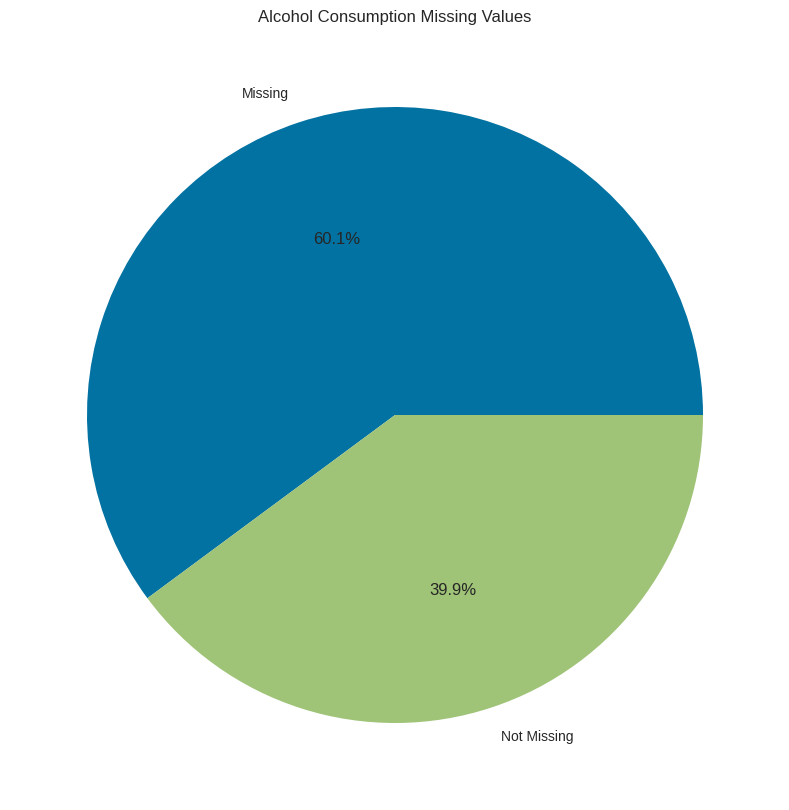

In [10]:
jumlah_missing = df['alcohol_consumption'].isna().sum()

plt.figure(figsize=(15, 10))
plt.title("Alcohol Consumption Missing Values")
plt.pie([jumlah_missing, df.shape[0] - jumlah_missing],
        labels=['Missing', 'Not Missing'],
        autopct="%1.1f%%")
plt.show()

Missing lebih dari 50%, jadi sebaiknya fitur alcohol_consumption dihapus saja.

## **Analisis Distribusi dan Korelasi**

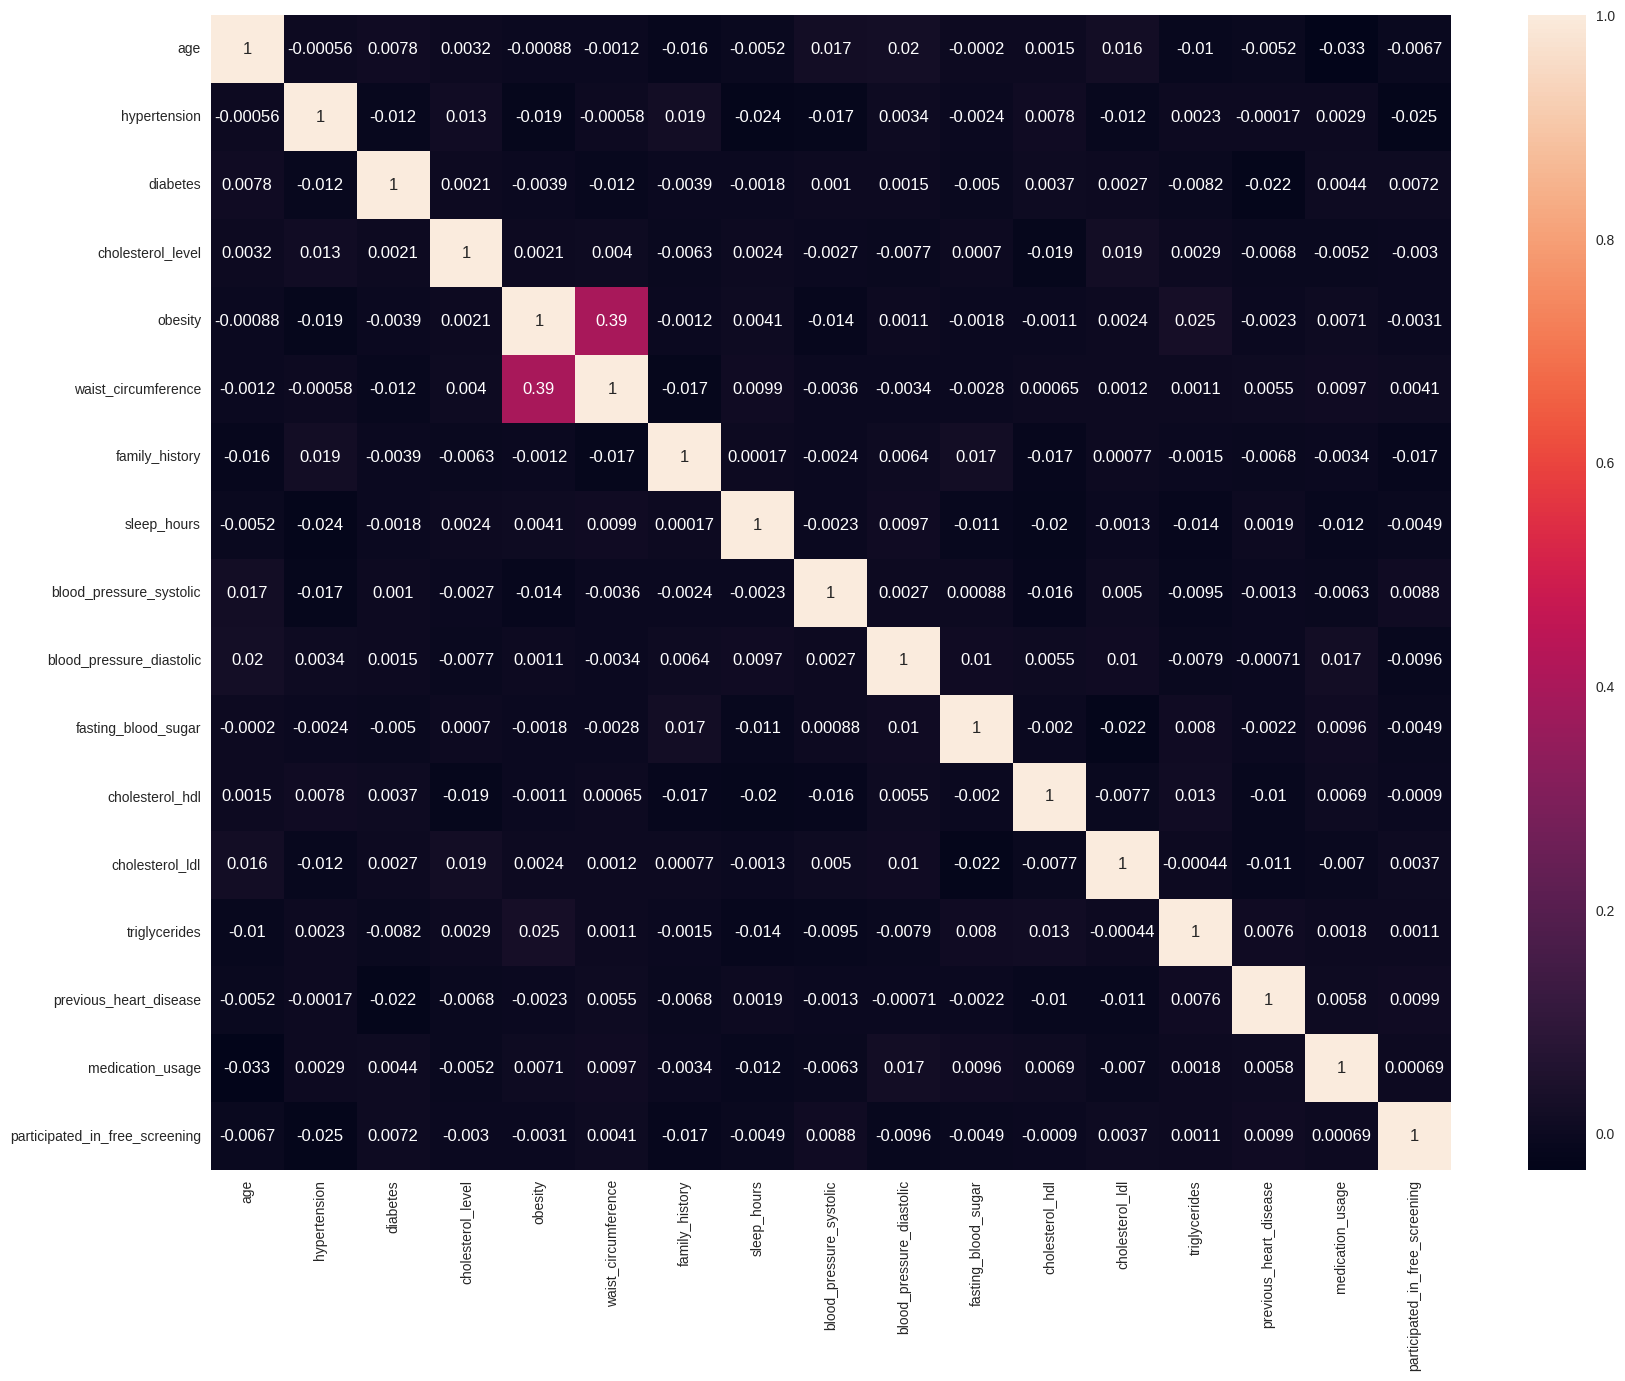

In [11]:
plt.figure(figsize=(20,15))
sns.heatmap(df.select_dtypes(exclude='object').corr(), annot=True)
plt.show()

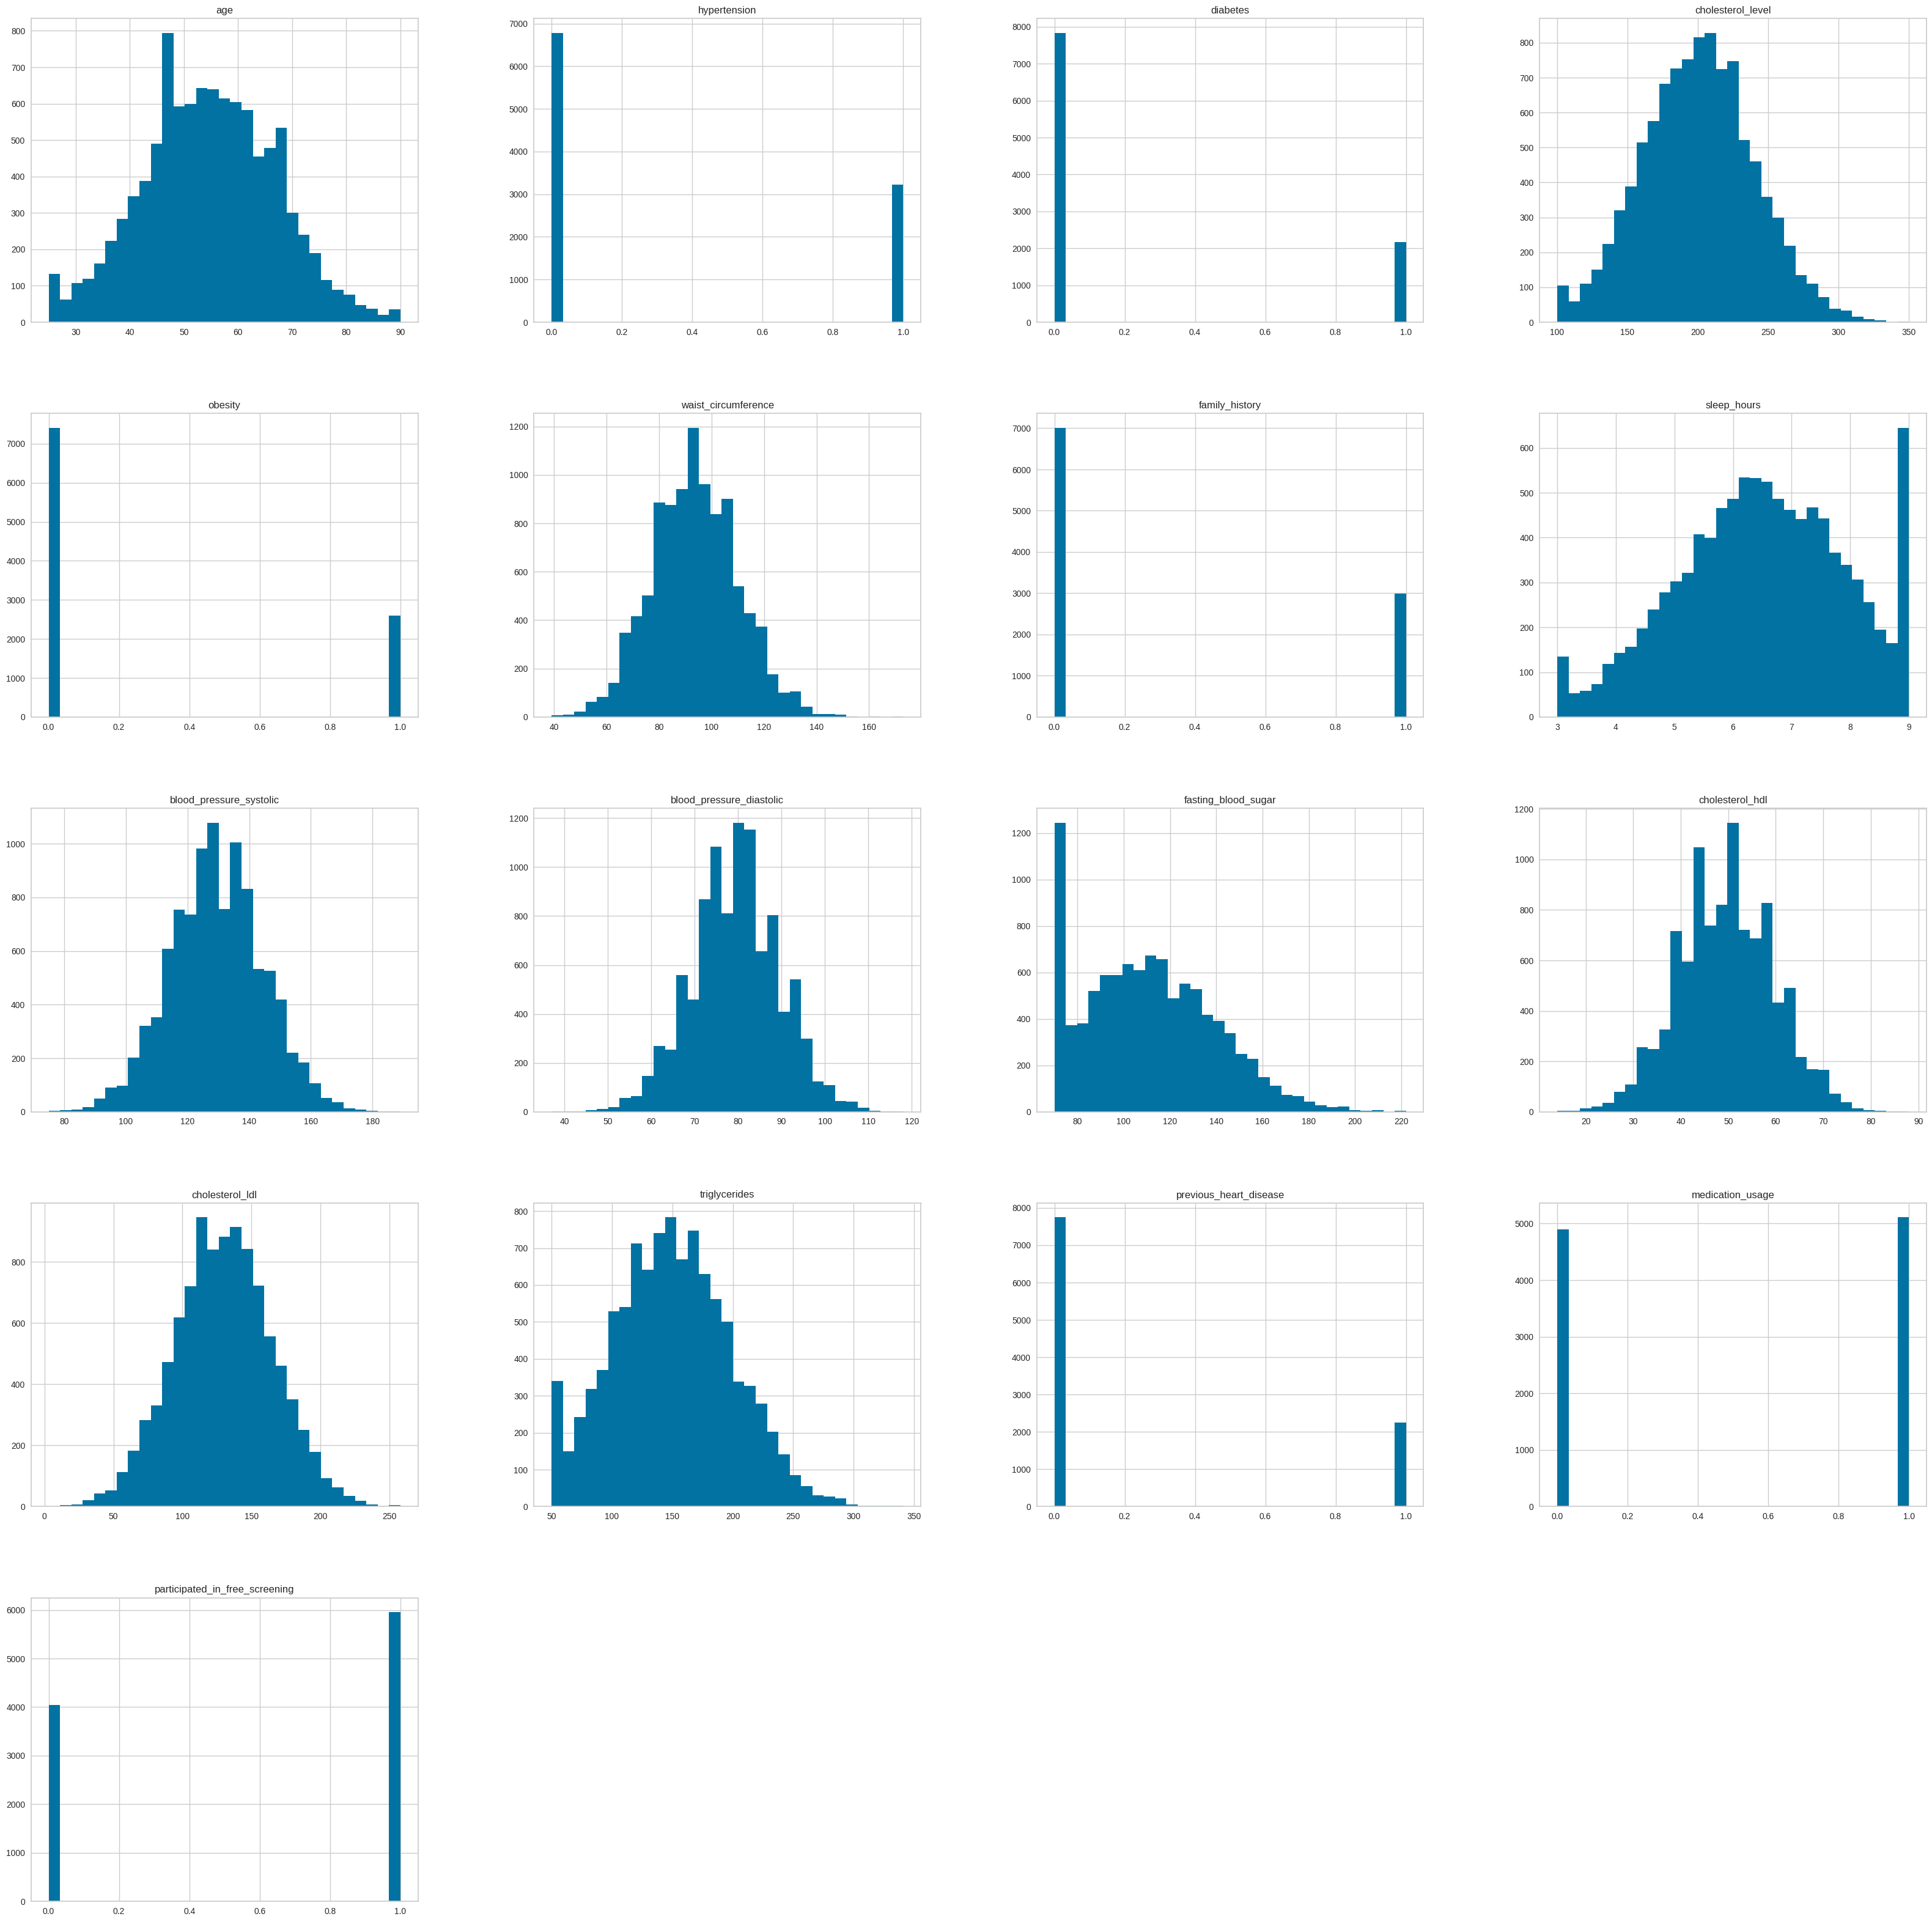

In [12]:
bins = int(1 + 3.3 * np.log(df.shape[0]))
df.hist(figsize=(40, 40), bins=bins)
plt.show()

## **Visualisasi Data**

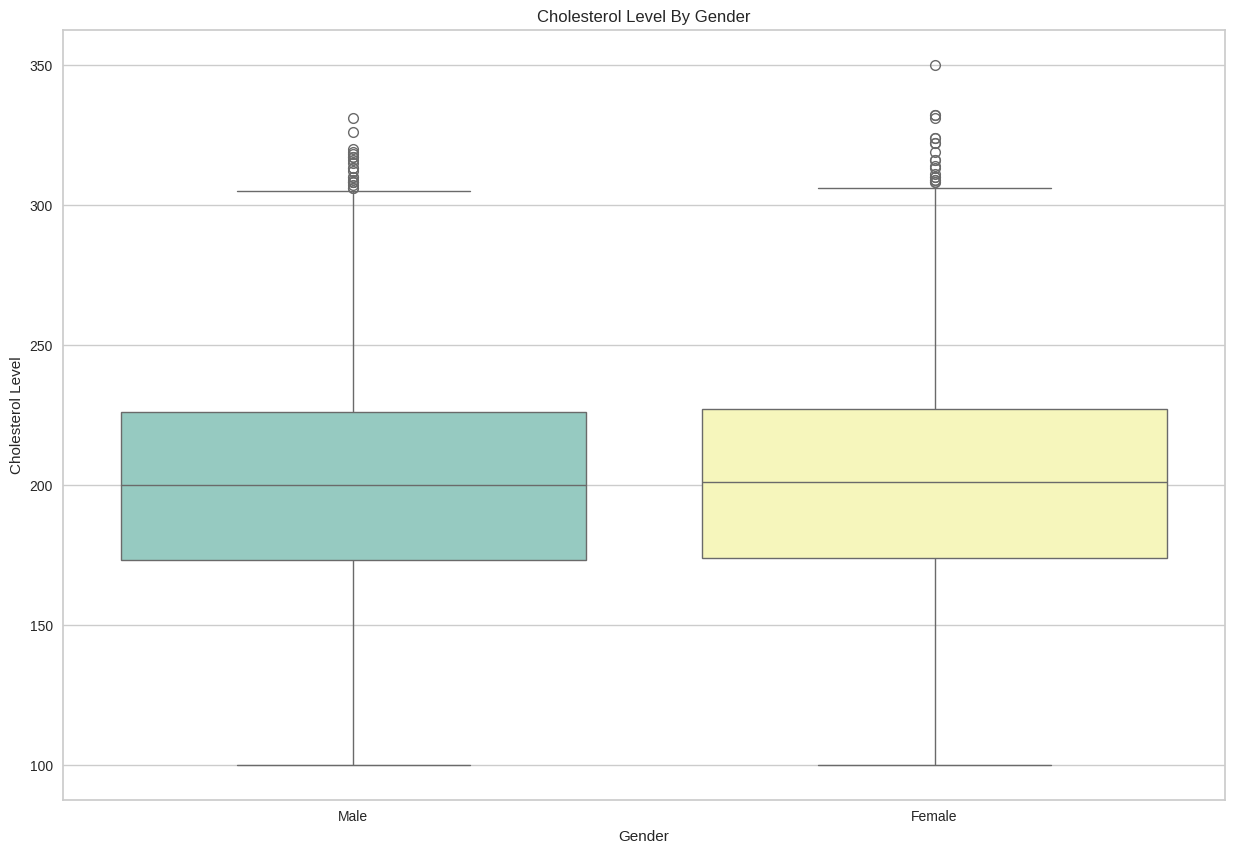

In [13]:
plt.figure(figsize=(15,10))
sns.boxplot(x='gender', y='cholesterol_level', data=df, palette='Set3')
plt.title('Cholesterol Level By Gender')
plt.xlabel('Gender')
plt.ylabel('Cholesterol Level')
plt.show()

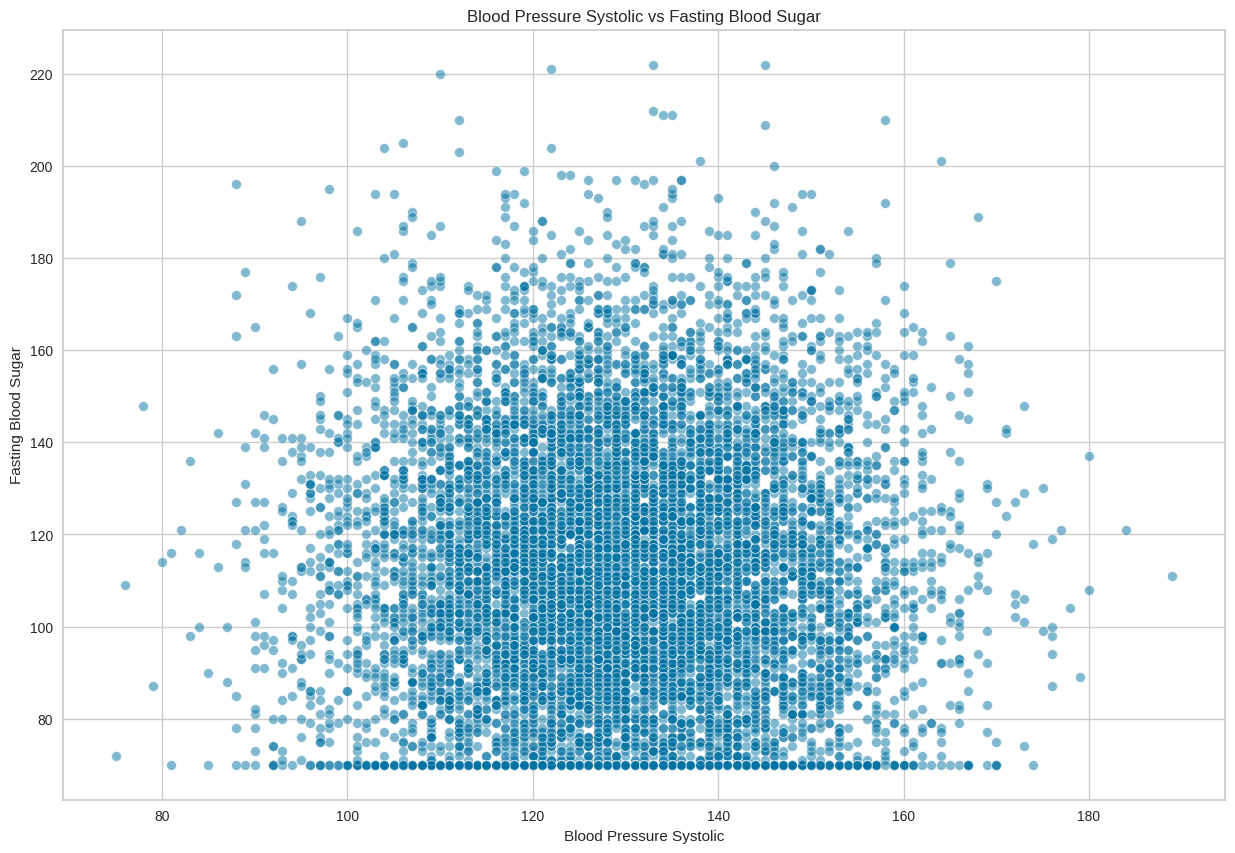

In [14]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='blood_pressure_systolic', y='fasting_blood_sugar', data=df, alpha=0.5)
plt.title('Blood Pressure Systolic vs Fasting Blood Sugar')
plt.xlabel('Blood Pressure Systolic')
plt.ylabel('Fasting Blood Sugar')
plt.show()

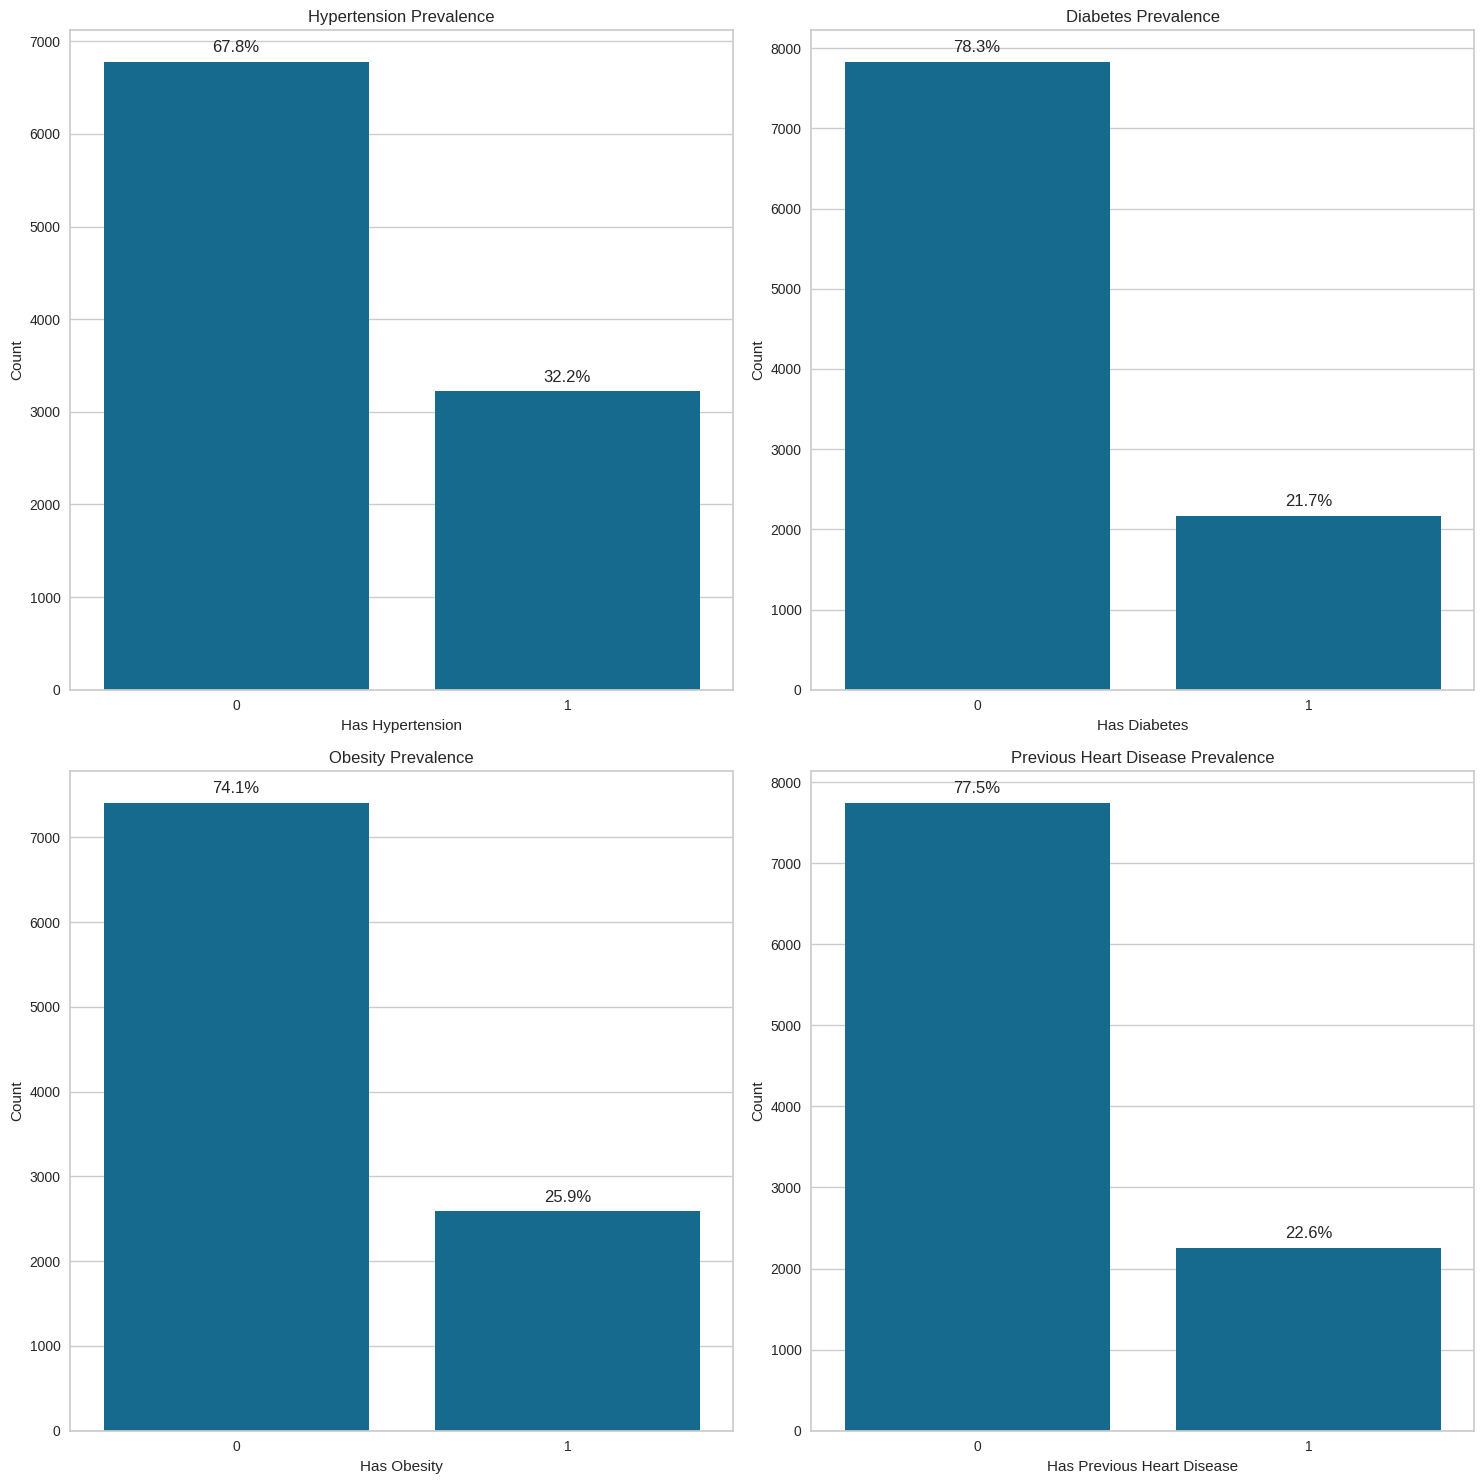

In [15]:
conditions = ['hypertension', 'diabetes', 'obesity', 'previous_heart_disease']

plt.figure(figsize=(15, 15))

for i, condition in enumerate(conditions, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=condition, data=df)
    plt.title(f'{condition.replace("_", " ").title()} Prevalence')
    plt.xlabel(f'Has {condition.replace("_", " ").title()}')
    plt.ylabel('Count')

    total = len(df)

    for p in plt.gca().patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        plt.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

## **Menghapus Data Duplikat**

In [16]:
data_preprocessing = df.copy(deep=True)
data_preprocessing.drop_duplicates(inplace=True)

## **Encoding Data Kategorikal**

In [17]:
object_columns = data_preprocessing.select_dtypes(include='object').columns

for i in object_columns:
    print(data_preprocessing[i].value_counts())
    print('='*50)

gender
Male      5178
Female    4822
Name: count, dtype: int64
region
Urban    6484
Rural    3516
Name: count, dtype: int64
income_level
Middle    4508
Low       3948
High      1544
Name: count, dtype: int64
smoking_status
Never      4779
Current    2702
Past       2519
Name: count, dtype: int64
alcohol_consumption
Moderate    3012
High         974
Name: count, dtype: int64
physical_activity
Moderate    3982
Low         3968
High        2050
Name: count, dtype: int64
dietary_habits
Unhealthy    5926
Healthy      4074
Name: count, dtype: int64
air_pollution_exposure
Moderate    4964
Low         3056
High        1980
Name: count, dtype: int64
stress_level
Moderate    4901
High        3077
Low         2022
Name: count, dtype: int64
EKG_results
Normal      8040
Abnormal    1960
Name: count, dtype: int64


In [18]:
gender_mapping = {"Male":1, "Female":0}
region_mapping = {"Urban":1, "Rural":0}
income_mapping = {"Low": 2, "Middle": 1, "High": 0}
smoking_mapping = {"Never": 0, "Past": 1, "Current": 2}
physical_mapping = {"Low": 0, "Moderate": 1, "High": 2}
dietary_mapping = {"Healthy": 0, "Unhealthy": 1}
air_pollution_mapping = {"Low": 0, "Moderate": 1, "High": 2}
stress_mapping = {"Low": 0, "Moderate": 1, "High": 2}
ekg_mapping = {"Normal": 0, "Abnormal": 1}

In [19]:
data_preprocessing['gender'] = data_preprocessing['gender'].map(gender_mapping)
data_preprocessing['region'] = data_preprocessing['region'].map(region_mapping)
data_preprocessing['income_level'] = data_preprocessing['income_level'].map(income_mapping)
data_preprocessing['smoking_status'] = data_preprocessing['smoking_status'].map(smoking_mapping)
data_preprocessing['physical_activity'] = data_preprocessing['physical_activity'].map(physical_mapping)
data_preprocessing['dietary_habits'] = data_preprocessing['dietary_habits'].map(dietary_mapping)
data_preprocessing['air_pollution_exposure'] = data_preprocessing['air_pollution_exposure'].map(air_pollution_mapping)
data_preprocessing['stress_level'] = data_preprocessing['stress_level'].map(stress_mapping)
data_preprocessing['EKG_results'] = data_preprocessing['EKG_results'].map(ekg_mapping )

## **Menghapus atau Menangani Data Kosong (Missing Values)**

In [20]:
data_preprocessing.dropna(axis=1, inplace=True)

## **Deteksi dan Penanganan Outlier**

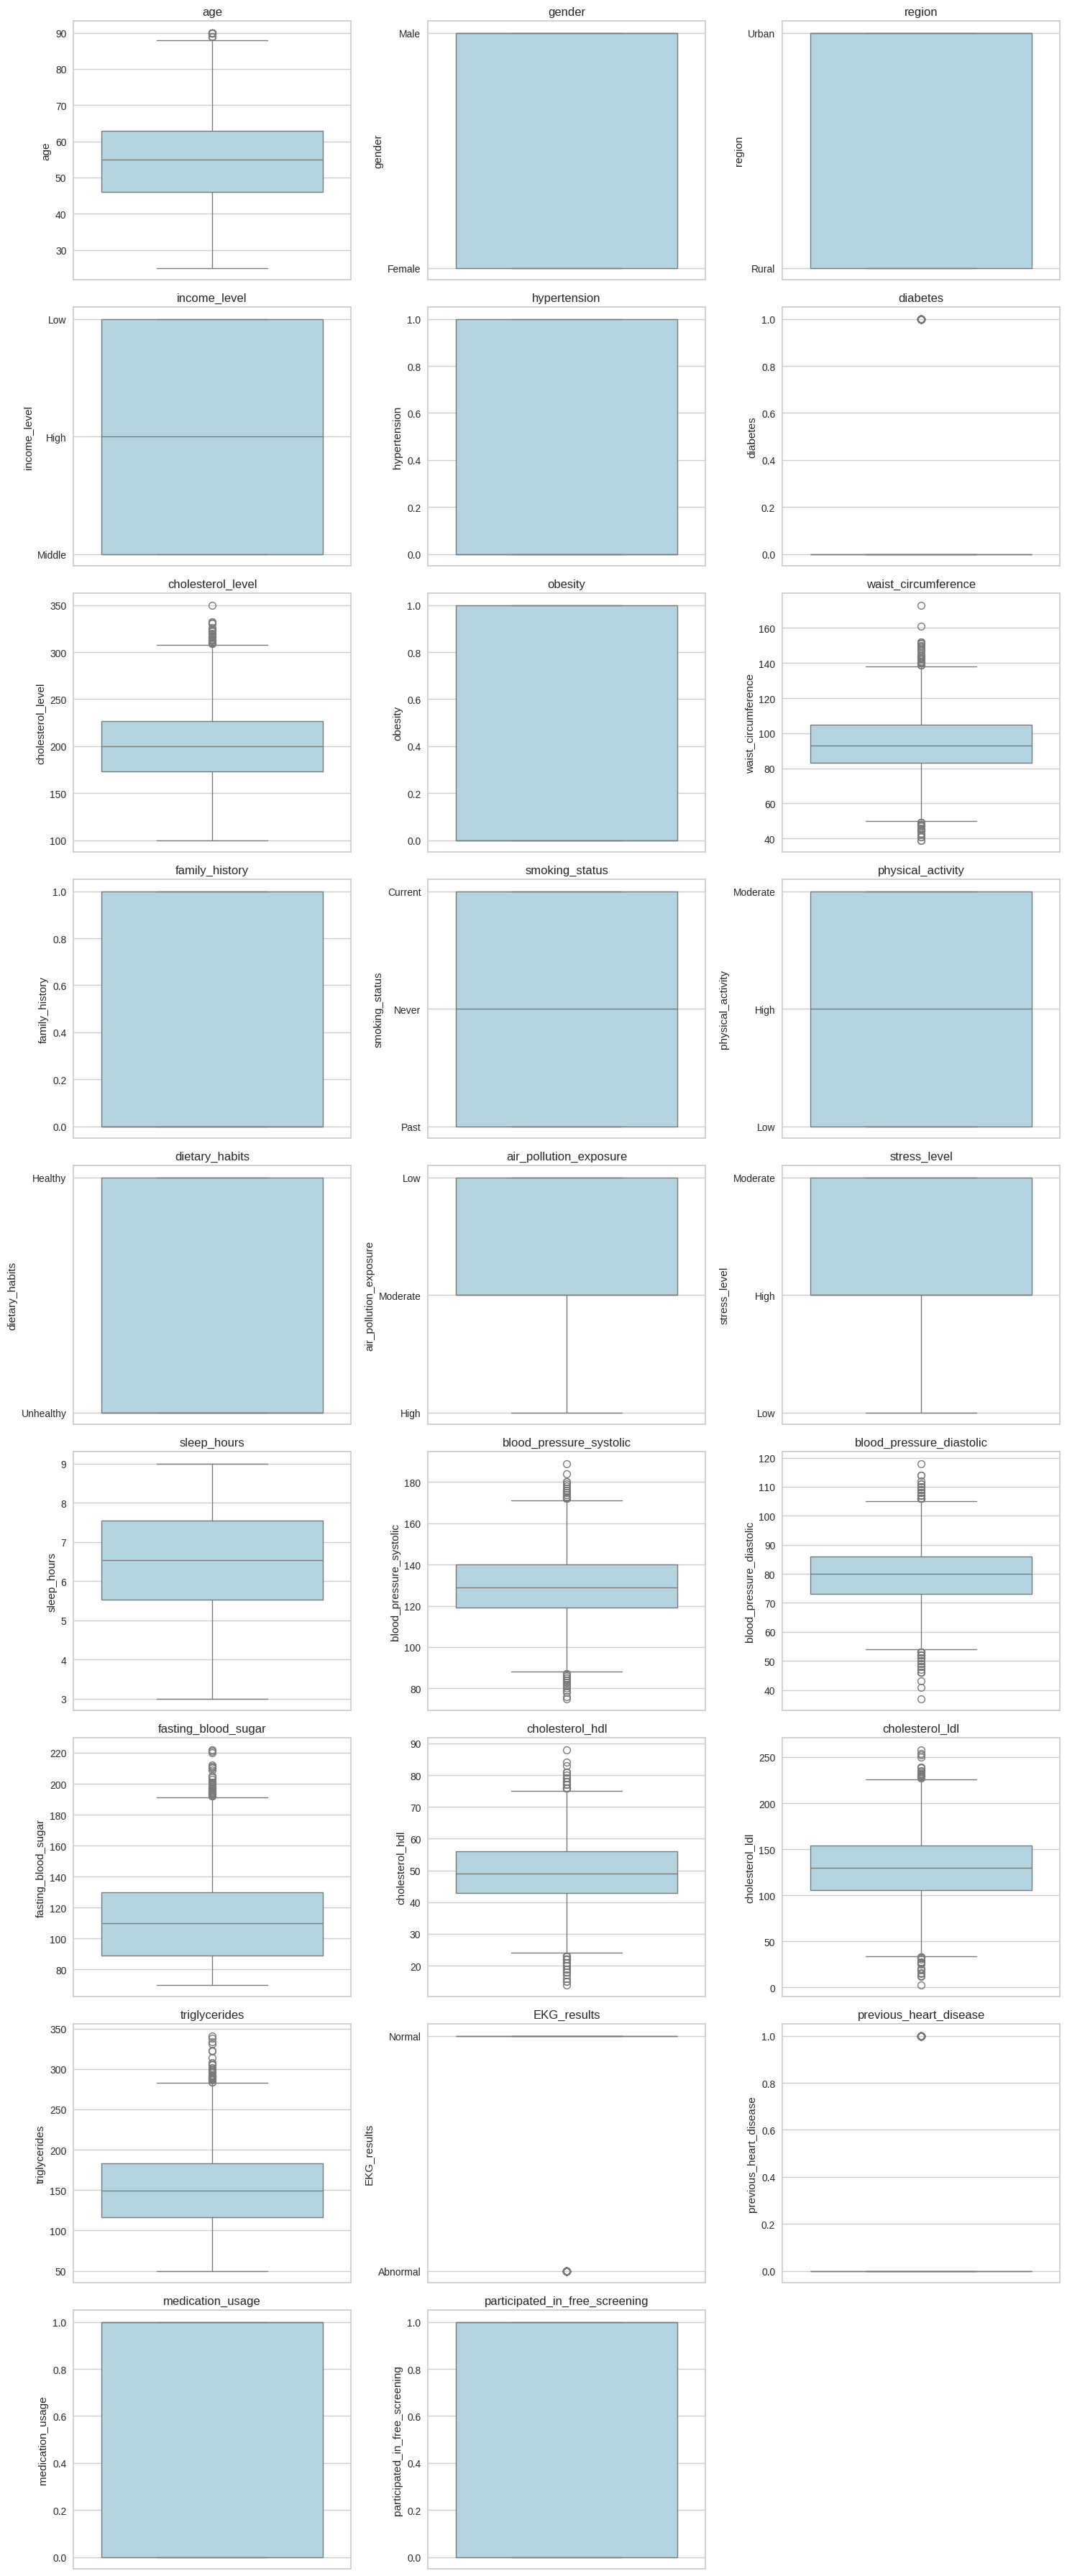

In [21]:
data_columns = data_preprocessing.columns
n_cols = 3
n_rows = (len(data_columns) + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(data_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(col)
    plt.tight_layout()

plt.show()

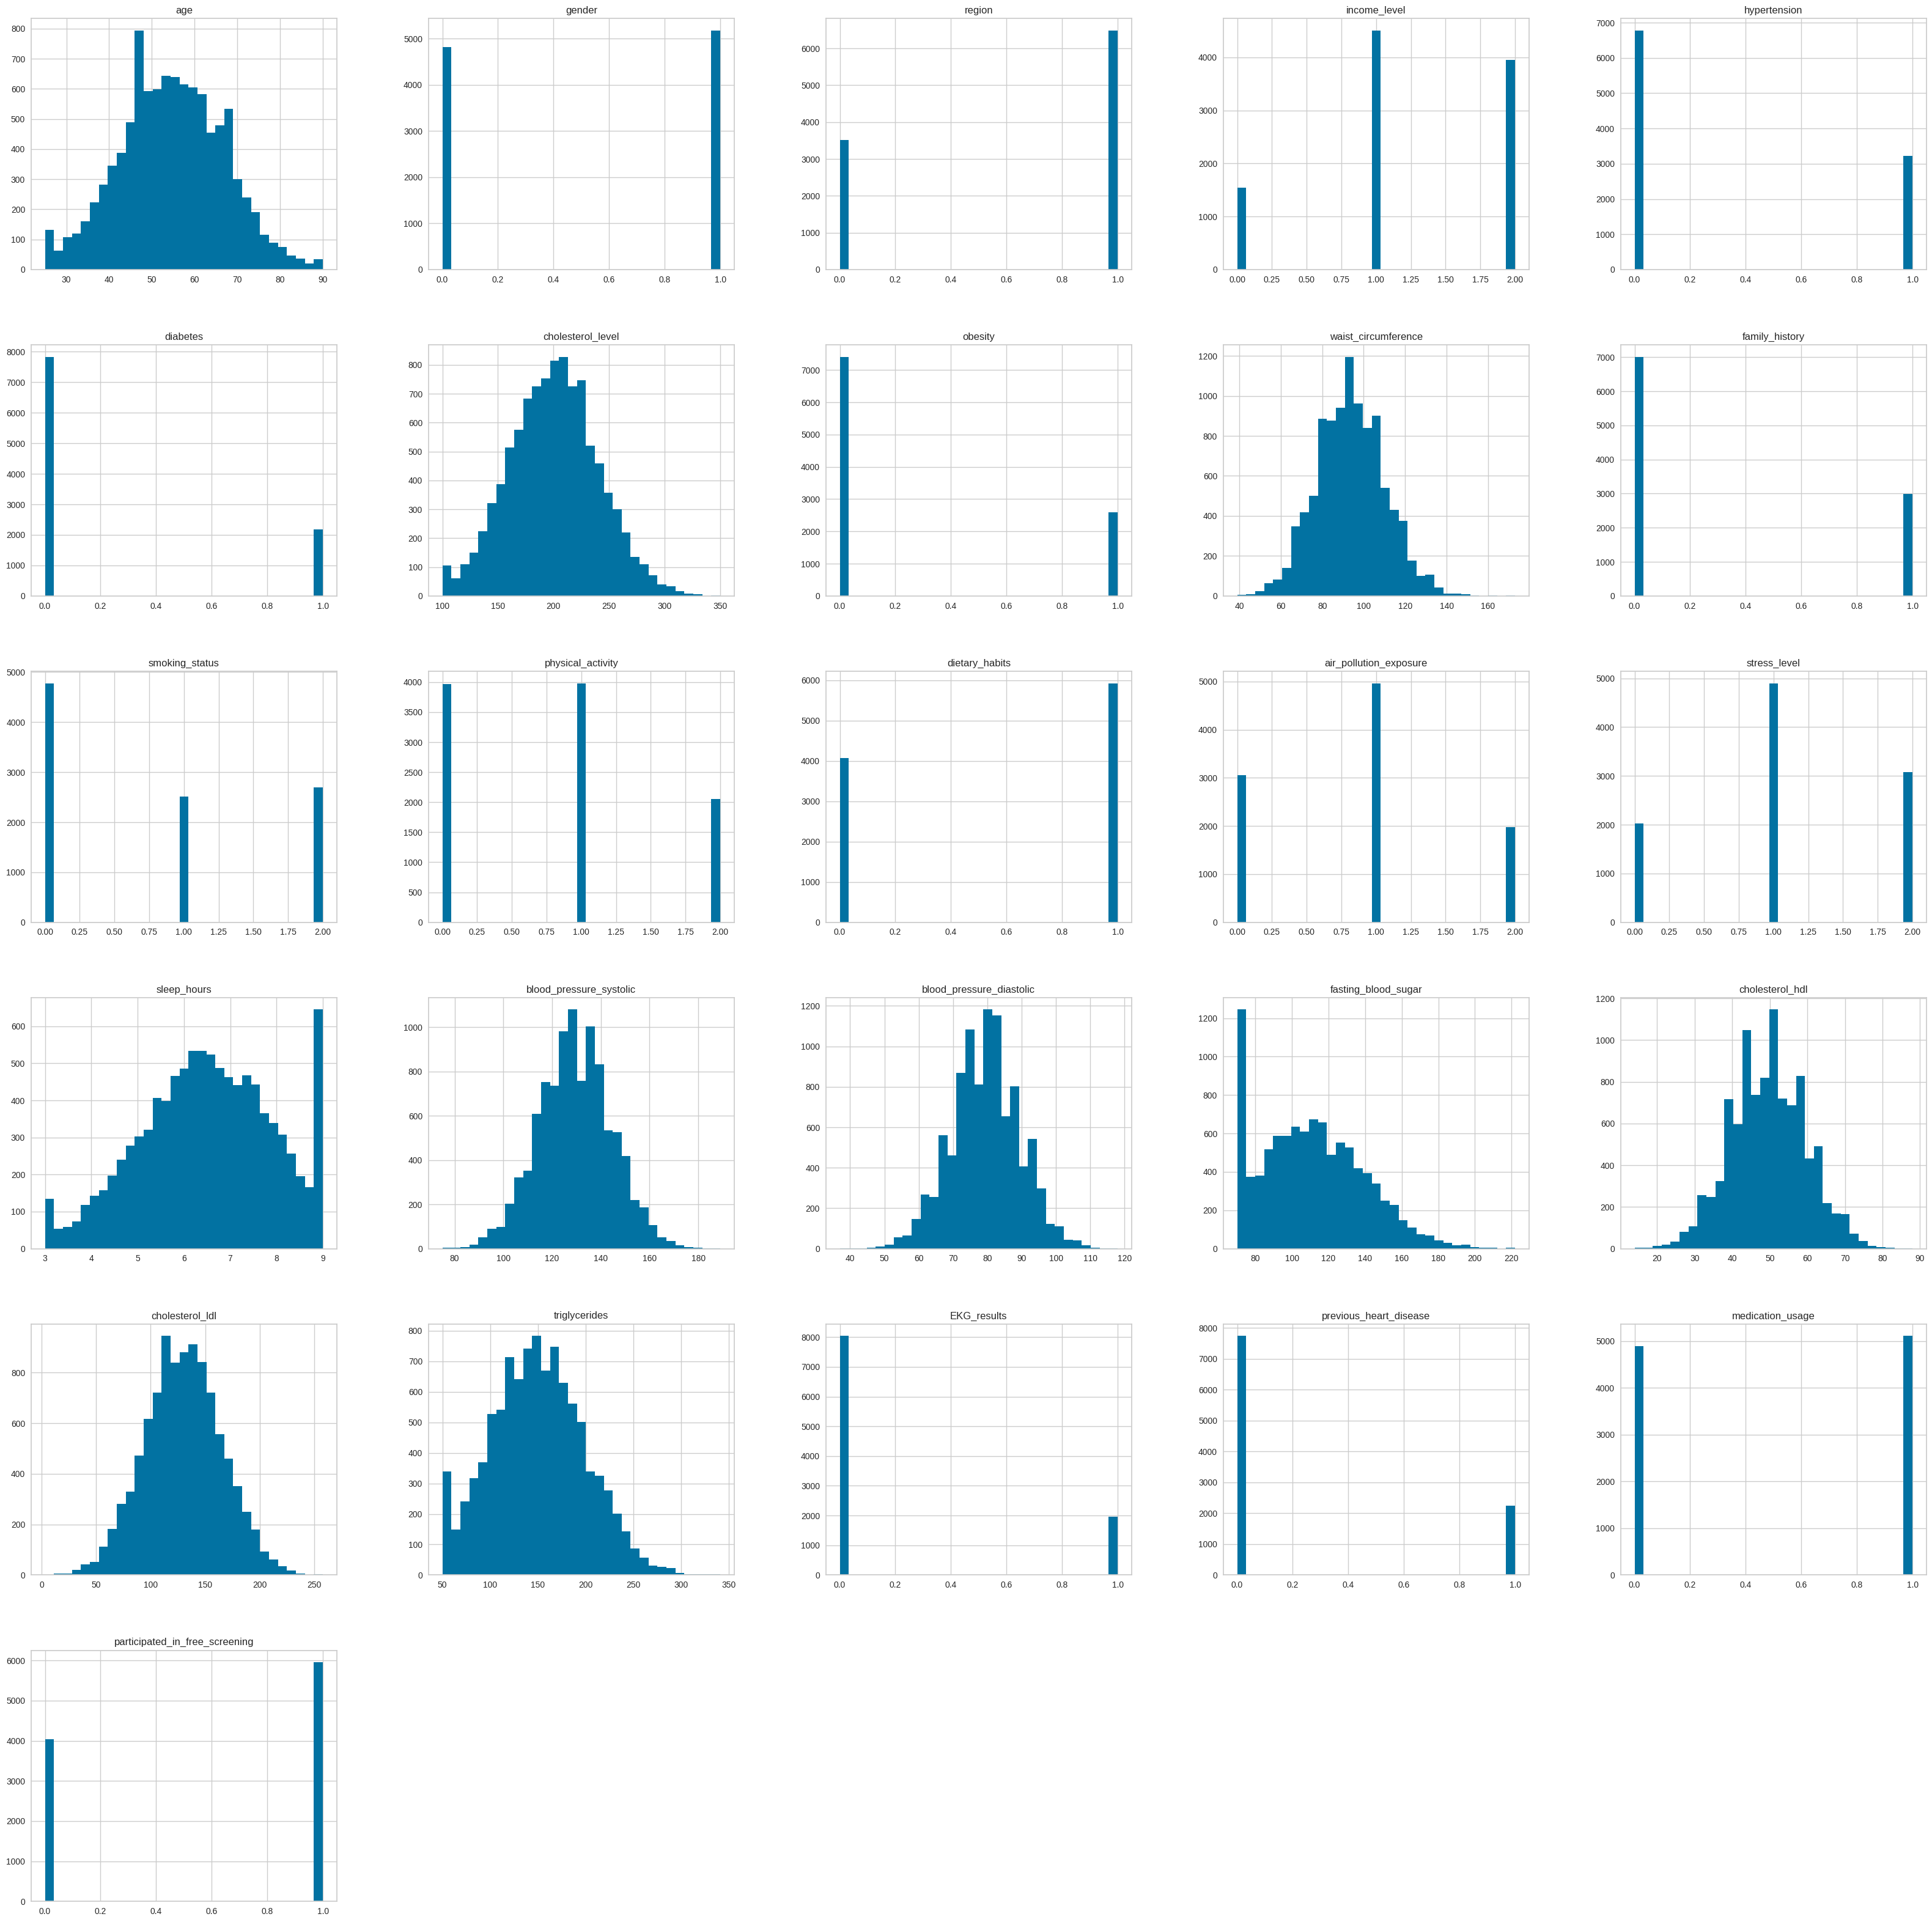

In [22]:
bins = int(1 + 3.3 * np.log(data_preprocessing.shape[0]))
data_preprocessing.hist(figsize=(40, 40), bins=bins)
plt.show()

In [23]:
con_columns = ["age", "cholesterol_level", "waist_circumference", "sleep_hours",
               "blood_pressure_systolic", "blood_pressure_diastolic",
               "fasting_blood_sugar", "cholesterol_hdl", "cholesterol_ldl",
               "triglycerides"]

In [24]:
def calculate_iqr_bounds(data):

    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    q05 = np.percentile(data, 5)
    q95 = np.percentile(data, 95)

    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    return lower_bound, upper_bound, q05, q95

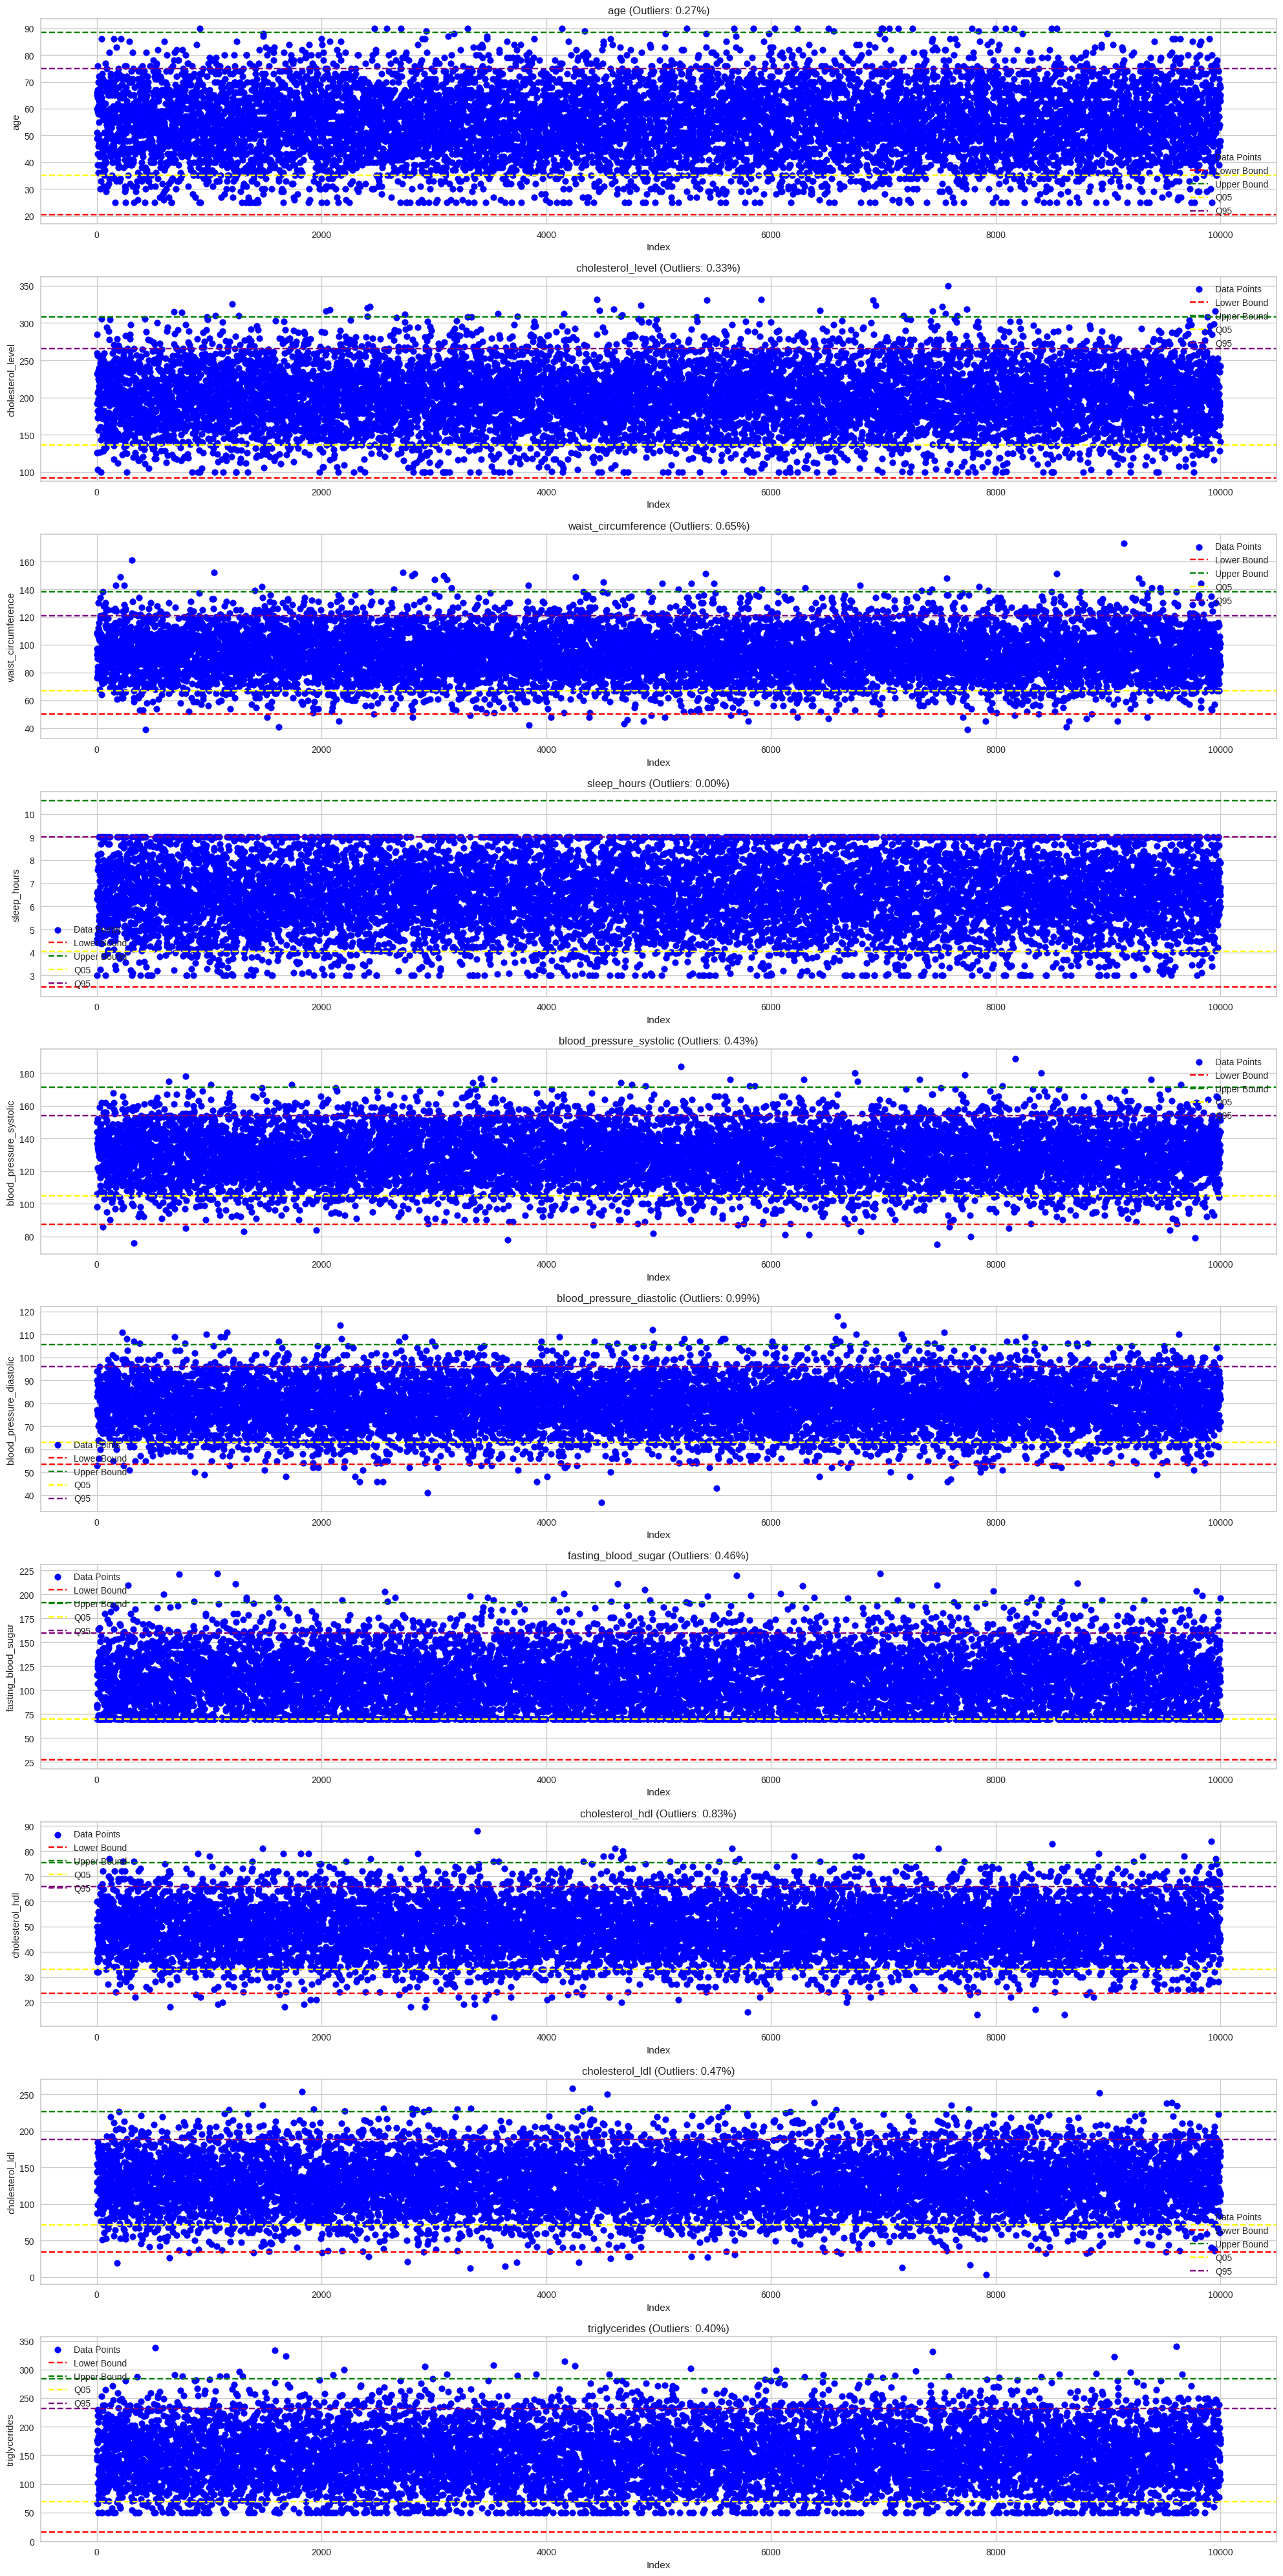

In [25]:
fig, ax = plt.subplots(len(con_columns), 1, figsize=(20, 40))

for i, column in enumerate(con_columns):
    lower_bound, upper_bound, q05, q95 = calculate_iqr_bounds(data_preprocessing[column])

    outlier_mask = (data_preprocessing[column] < lower_bound) | (data_preprocessing[column] > upper_bound)
    n_outliers = outlier_mask.sum()
    total = len(data_preprocessing[column])
    percent_outliers = (n_outliers / total) * 100

    ax[i].scatter(data_preprocessing.index, data_preprocessing[column], color='blue', label='Data Points')

    ax[i].axhline(y=lower_bound, color='red', linestyle='--', label='Lower Bound')
    ax[i].axhline(y=upper_bound, color='green', linestyle='--', label='Upper Bound')
    ax[i].axhline(y=q05, color='yellow', linestyle='--', label='Q05')
    ax[i].axhline(y=q95, color='purple', linestyle='--', label='Q95')

    ax[i].set_title(f"{column} (Outliers: {percent_outliers:.2f}%)")
    ax[i].set_xlabel('Index')
    ax[i].set_ylabel(column)

    ax[i].legend()

plt.tight_layout()
plt.show()

In [26]:
data_preprocessing[con_columns] = data_preprocessing[con_columns].apply(lambda x: winsorize(x, (0.05, 0.05)))

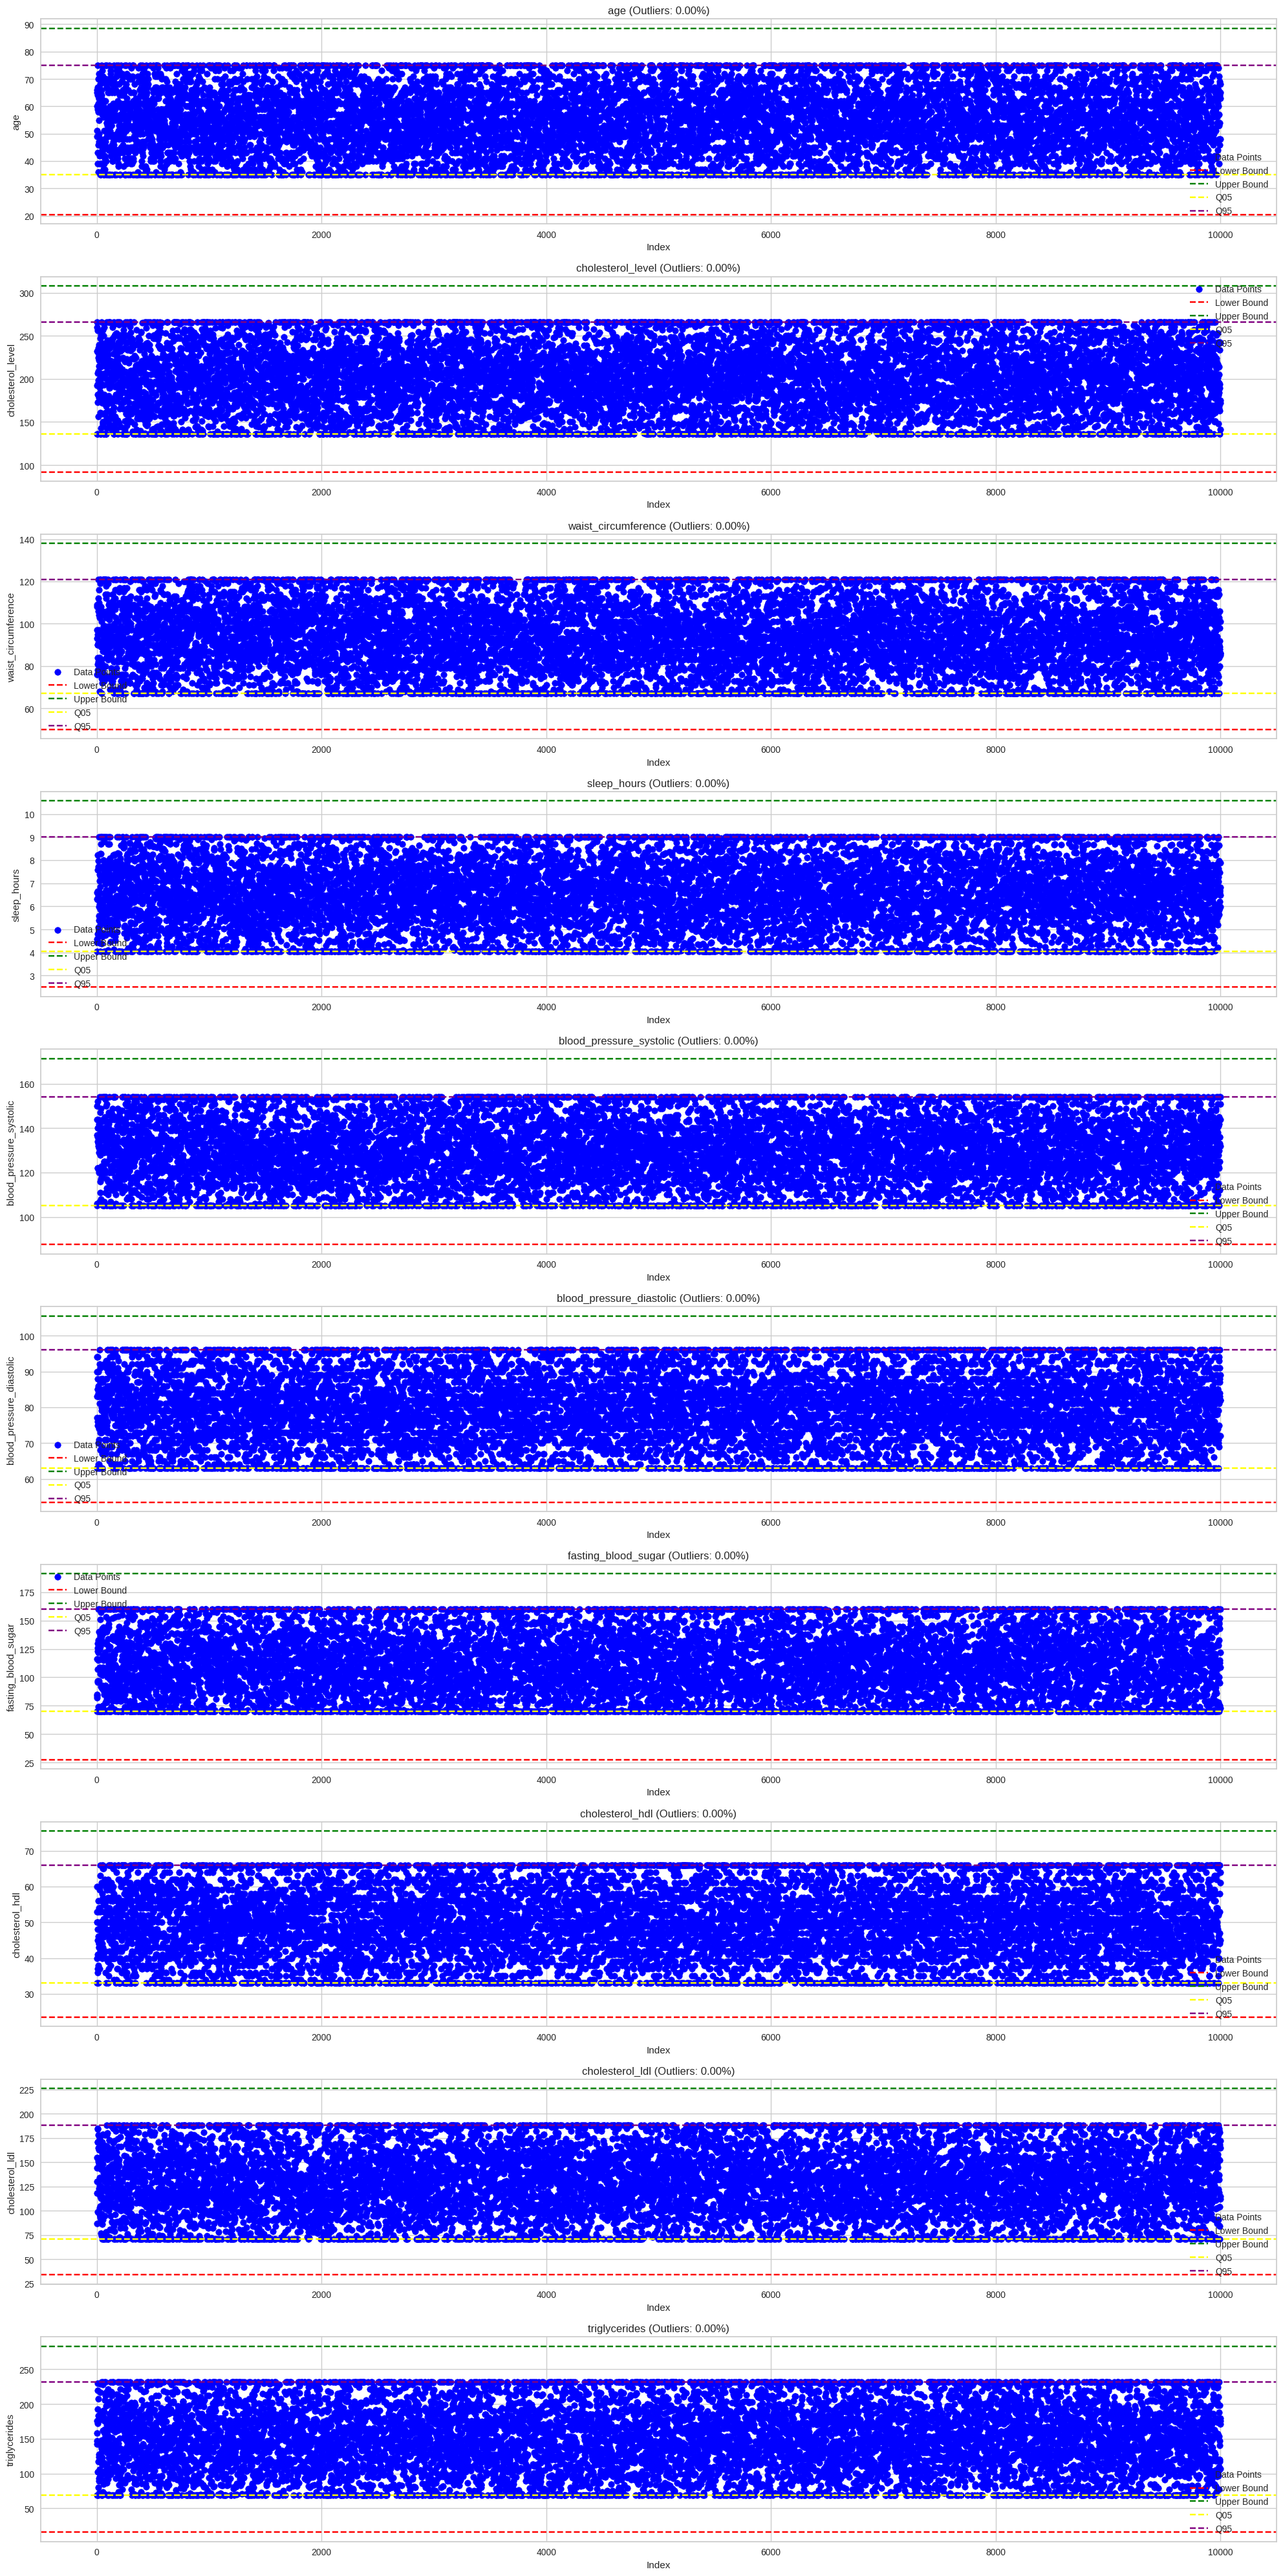

In [27]:
fig, ax = plt.subplots(len(con_columns), 1, figsize=(20, 40))

for i, column in enumerate(con_columns):
    lower_bound, upper_bound, q05, q95 = calculate_iqr_bounds(data_preprocessing[column])

    outlier_mask = (data_preprocessing[column] < lower_bound) | (data_preprocessing[column] > upper_bound)
    n_outliers = outlier_mask.sum()
    total = len(data_preprocessing[column])
    percent_outliers = (n_outliers / total) * 100

    ax[i].scatter(data_preprocessing.index, data_preprocessing[column], color='blue', label='Data Points')

    ax[i].axhline(y=lower_bound, color='red', linestyle='--', label='Lower Bound')
    ax[i].axhline(y=upper_bound, color='green', linestyle='--', label='Upper Bound')
    ax[i].axhline(y=q05, color='yellow', linestyle='--', label='Q05')
    ax[i].axhline(y=q95, color='purple', linestyle='--', label='Q95')

    ax[i].set_title(f"{column} (Outliers: {percent_outliers:.2f}%)")
    ax[i].set_xlabel('Index')
    ax[i].set_ylabel(column)

    ax[i].legend()

plt.tight_layout()
plt.show()

## **Normalisasi atau Standarisasi Fitur**

In [28]:
scaler = StandardScaler()
data_pre_scaled = scaler.fit_transform(data_preprocessing)

data_pre_scaled = pd.DataFrame(data_pre_scaled, columns=data_preprocessing.columns, index=data_preprocessing.index)

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

### **K-Means**

In [29]:
kmeans = KMeans()

visualizer = KElbowVisualizer(kmeans, k=(1, 10))

### **DBSCAN**

In [30]:
min_samples_range = range(2, 100, 5)
eps_value = 0.5
sil_scores = []
n_clusters_list = []

for min_samp in min_samples_range:
    clusterer = DBSCAN(eps=eps_value, min_samples=min_samp)
    labels = clusterer.fit_predict(data_pre_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_list.append(n_clusters)

    if n_clusters > 1:
        # Filter out noise points for silhouette calculation
        mask = labels != -1
        if np.sum(mask) > 0:  # Ensure we have points to calculate score
            score = silhouette_score(data_pre_scaled[mask], labels[mask])
            sil_scores.append(score)
        else:
            sil_scores.append(np.nan)
    else:
        sil_scores.append(np.nan)
        print("Tidak Ada Cluster Yang Terbentuk!")

Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!
Tidak Ada Cluster Yang Terbentuk!


## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [31]:
def calculate_silhouette(labels, data):
    mask = labels != -1
    if len(np.unique(labels[mask])) < 2:
        return 999
    else:
        return silhouette_score(data[mask], labels[mask])

### **Hasil K-Means**

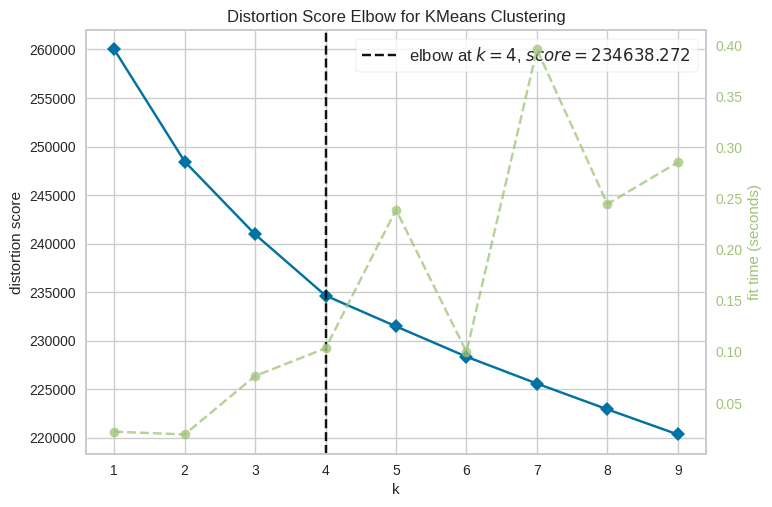

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
visualizer.fit(data_pre_scaled)
visualizer.show()

In [33]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(data_pre_scaled)

In [34]:
kmeans_silhouette = calculate_silhouette(kmeans_labels, data_pre_scaled)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")

K-Means Silhouette Score: 0.0272


### **Hasil DSBCAN**

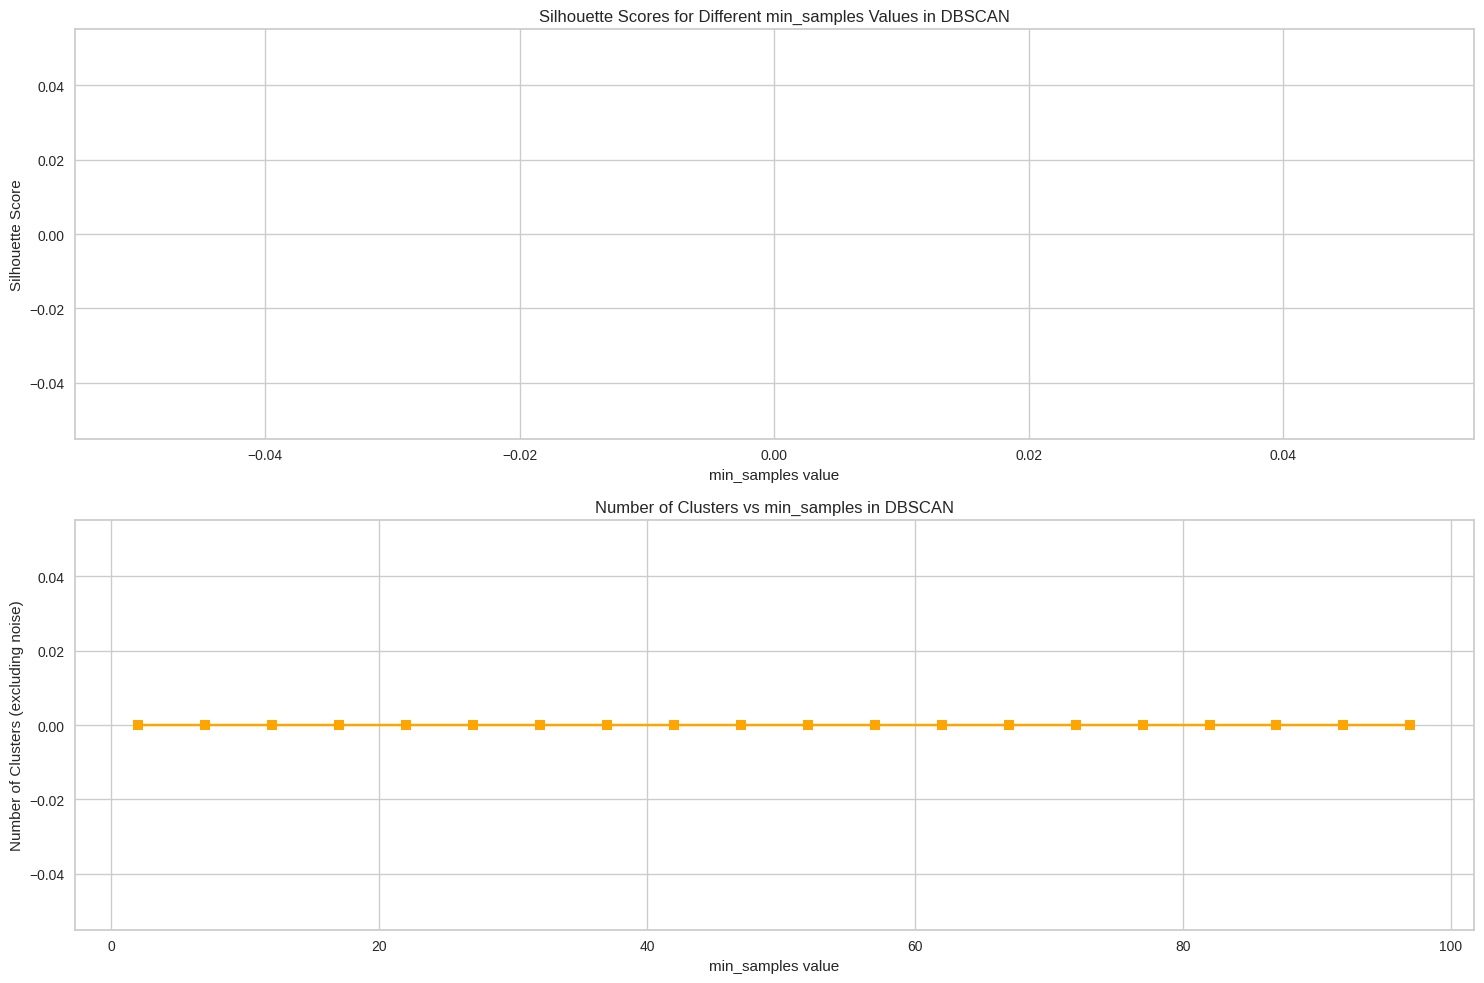

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot silhouette scores
axs[0].plot(list(min_samples_range), sil_scores, marker='o', color='blue', linestyle='-')
axs[0].set_xlabel("min_samples value")
axs[0].set_ylabel("Silhouette Score")
axs[0].set_title("Silhouette Scores for Different min_samples Values in DBSCAN")
axs[0].grid(True)

# Plot number of clusters
axs[1].plot(list(min_samples_range), n_clusters_list, marker='s', color='orange', linestyle='-')
axs[1].set_xlabel("min_samples value")
axs[1].set_ylabel("Number of Clusters (excluding noise)")
axs[1].set_title("Number of Clusters vs min_samples in DBSCAN")
axs[1].grid(True)

plt.tight_layout()
plt.show()

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

### **Domain Knowledge**

> Pemilihan fitur berdasarkan pemahaman domain dan hipotesis tentang apa yang mungkin berpengaruh pada pengelompokan. Dalam konteks data, indikator klinis yang relevan digunakan untuk mengelompokkan fitur.

In [36]:
dk_1 = data_pre_scaled[['age', 'gender', 'hypertension', 'diabetes', 'cholesterol_level', 'obesity', 'smoking_status', 'physical_activity', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'cholesterol_hdl', 'cholesterol_ldl']] # Faktor Risiko Kardiovaskular Utama
dk_2 = data_pre_scaled[['age', 'gender', 'region', 'income_level', 'hypertension', 'diabetes', 'family_history', 'smoking_status']] # Demografis dan Sosioekonomik
dk_3 = data_pre_scaled[['smoking_status','physical_activity', 'dietary_habits', 'air_pollution_exposure', 'stress_level', 'sleep_hours', 'income_level']]
dk_4 = data_pre_scaled[['age', 'gender', 'hypertension', 'diabetes', 'obesity', 'smoking_status', 'cholesterol_hdl', 'cholesterol_ldl']] # Profil Risiko Minimalis
dk_5 = data_pre_scaled[['age', 'gender', 'hypertension', 'cholesterol_level', 'smoking_status', 'physical_activity', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'cholesterol_hdl', 'cholesterol_ldl', 'EKG_results', 'previous_heart_disease']] # Indikator Kesehatan Jantung Komprehensif

### **Reduksi Dimensi**

In [37]:
list_hasil = {}

In [38]:
data_reduksi = dk_5
var_fe = "dk_5"
list_hasil[var_fe] = {}

### **Reduksi Dimensi dengan UMAP**

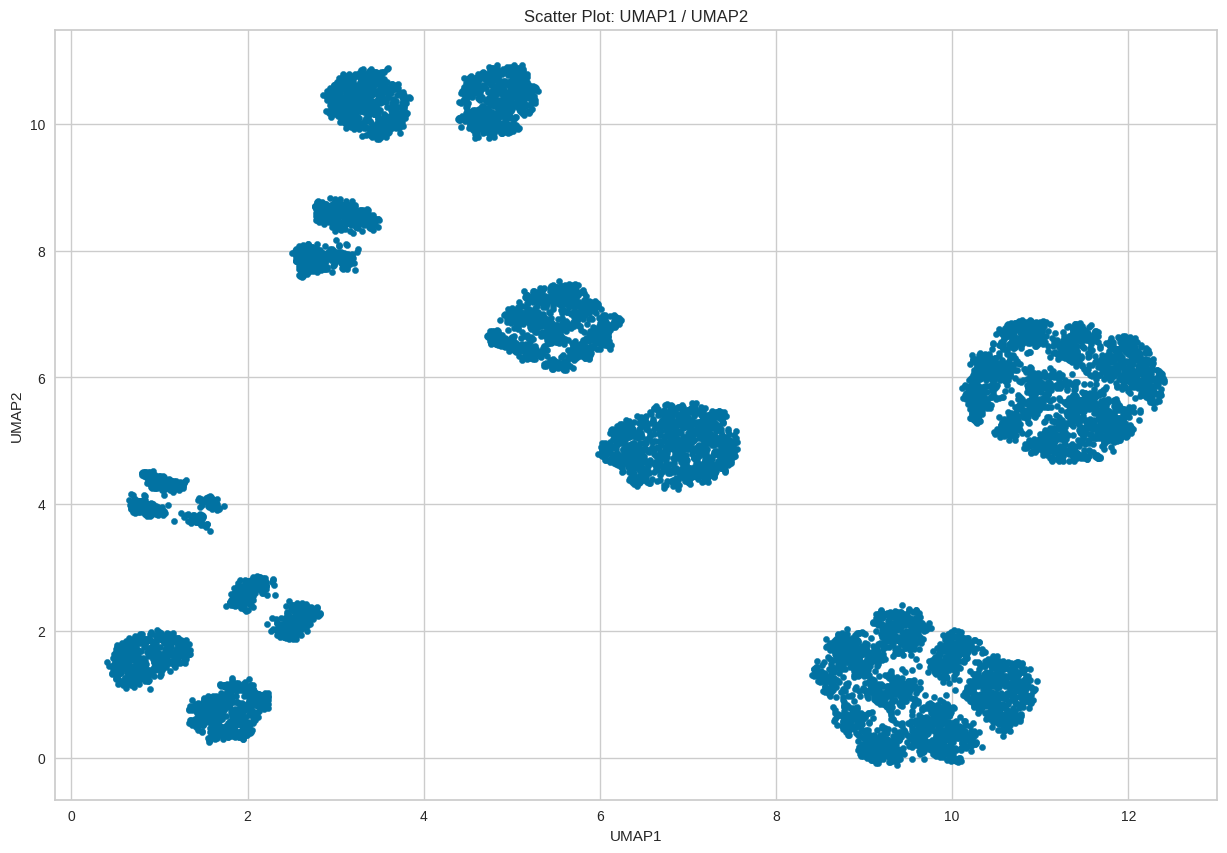

In [39]:
reducerUmap = umap.UMAP(n_neighbors=100, n_components=2, metric='euclidean', n_epochs=100, learning_rate=0.1, init='spectral',
                 min_dist=0.1, spread=1.0, low_memory=False, set_op_mix_ratio=1.0, local_connectivity=1,
                 repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, random_state=3,
                 angular_rp_forest=False, target_n_neighbors=-1, transform_seed=3, verbose=False, unique=False)

data_umap = reducerUmap.fit_transform(data_reduksi)

df_umap = pd.DataFrame(data_umap, columns=['UMAP1', 'UMAP2'])

df_umap.plot(figsize=(15,10), kind='scatter', x='UMAP1', y='UMAP2')
plt.title('Scatter Plot: UMAP1 / UMAP2')
plt.show()

### **Train dengan K-Means**

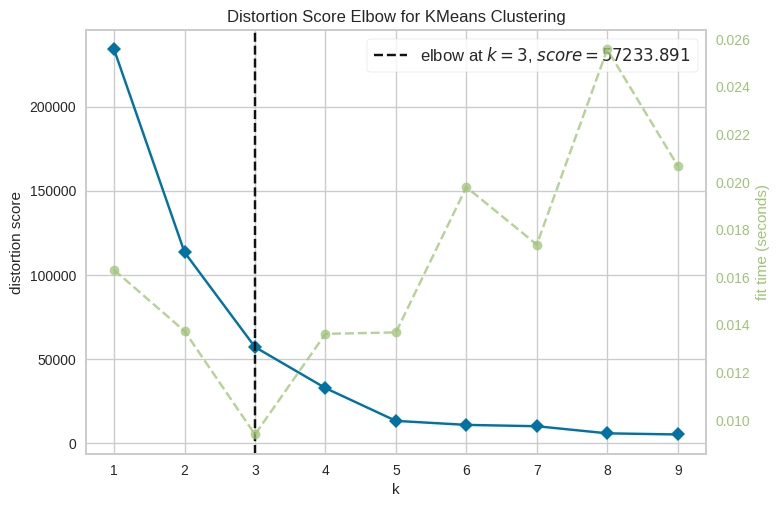

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
kmeans = KMeans()

visualizer = KElbowVisualizer(kmeans, k=(1, 10))
visualizer.fit(data_umap)
visualizer.show()

In [41]:
umap_kmeans_optimal = KMeans(n_clusters=4, random_state=42, n_init=10)
umap_kmeans_labels = umap_kmeans_optimal.fit_predict(data_umap)

In [42]:
umap_kmeans_silhouette = calculate_silhouette(umap_kmeans_labels, data_umap)
print(f"K-Means Silhouette Score: {umap_kmeans_silhouette:.4f}")

list_hasil[var_fe]['umap_kmeans'] = umap_kmeans_silhouette
list_hasil[var_fe]['umap_kmeans_cluster'] = umap_kmeans_optimal.n_clusters

K-Means Silhouette Score: 0.6237


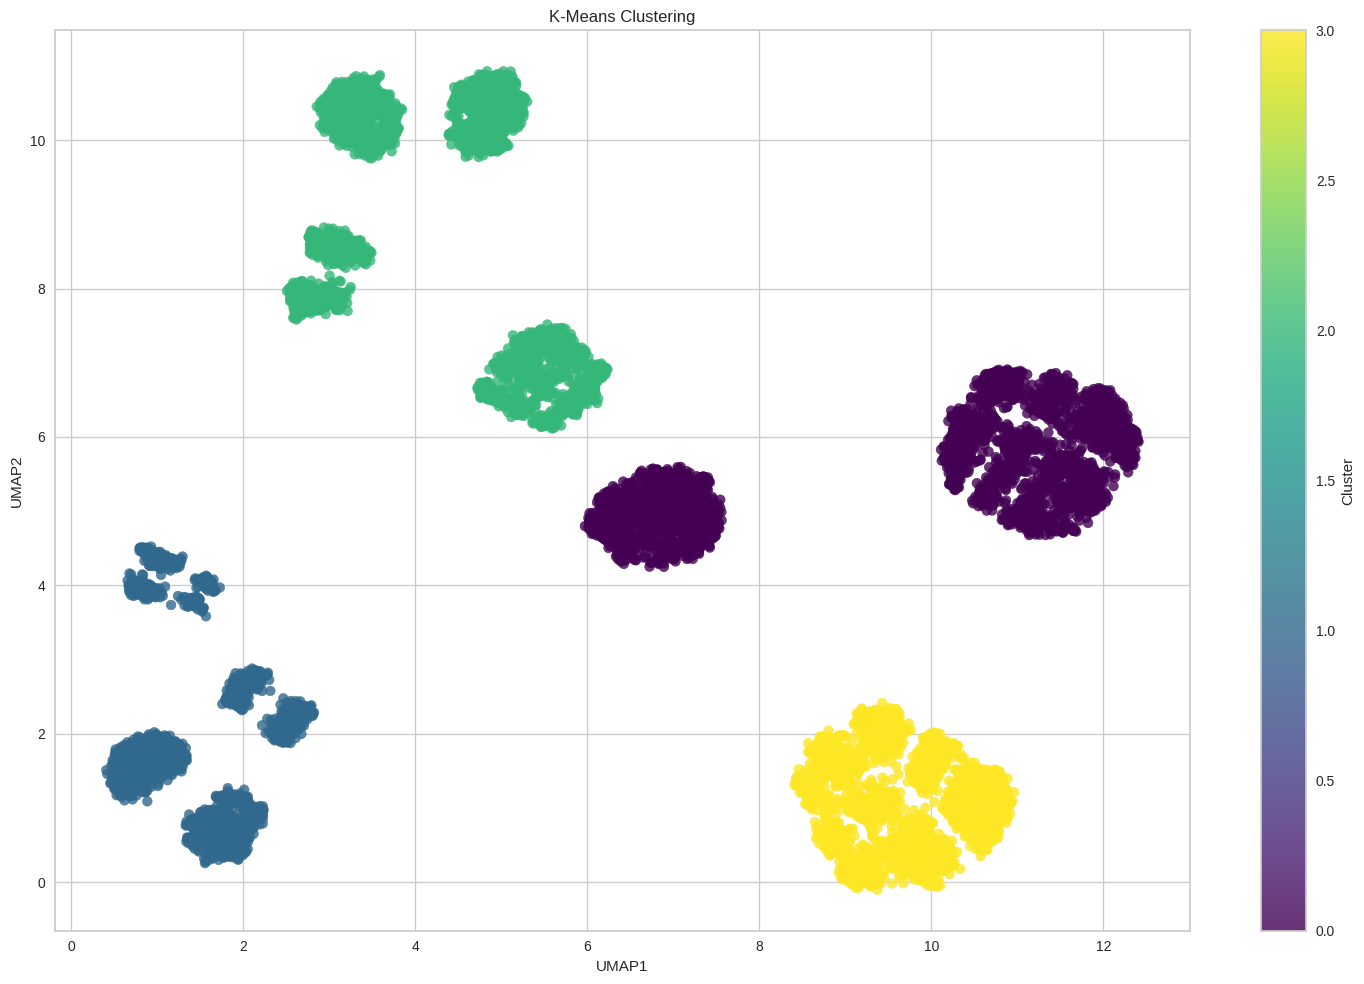

In [43]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(data_umap[:, 0], data_umap[:, 1], c=umap_kmeans_labels, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(scatter, label='Cluster')
plt.title(f'K-Means Clustering')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

### **Train dengan DBSCAN**

In [44]:
umap_dbscan = DBSCAN(eps=0.5, min_samples=20)
umap_dbscan_labels = umap_dbscan.fit_predict(data_umap)

In [45]:
umap_dbscan_silhouette = calculate_silhouette(umap_dbscan_labels, data_umap)
print(f"DBSCAN Silhouette Score: {umap_dbscan_silhouette:.4f}")

list_hasil[var_fe]['umap_dbscan'] = umap_dbscan_silhouette
list_hasil[var_fe]['umap_dbscan_cluster'] = len(set(umap_dbscan_labels)) - (1 if -1 in umap_dbscan_labels else 0)

DBSCAN Silhouette Score: 0.7286


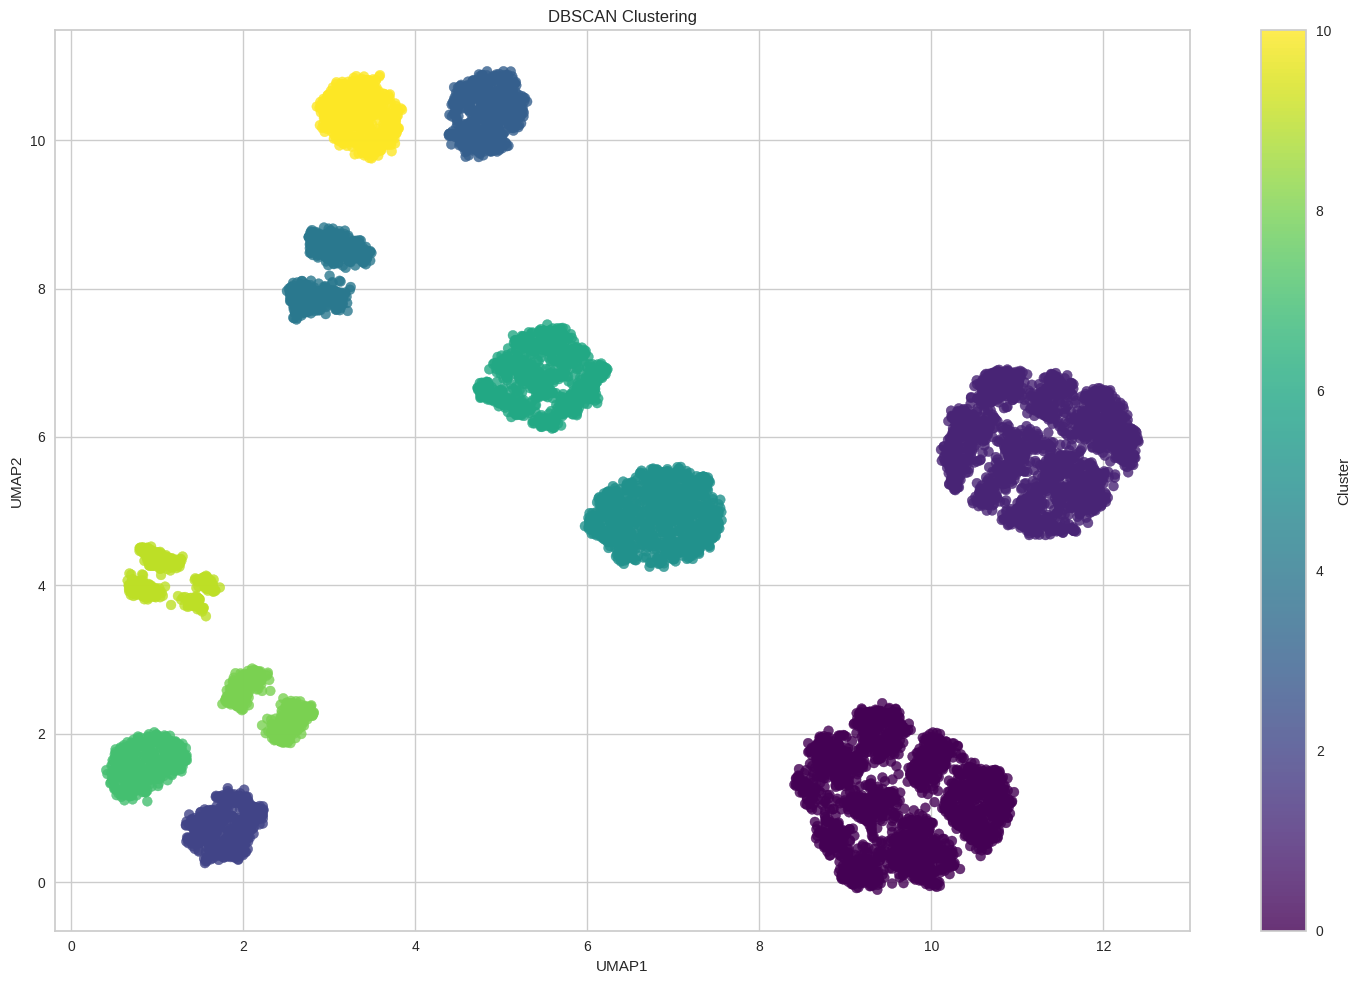

In [46]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(data_umap[:, 0], data_umap[:, 1], c=umap_dbscan_labels, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(scatter, label='Cluster')
plt.title(f'DBSCAN Clustering')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

### **Train Dengan HDBSCAN**

In [47]:
umap_hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=5)
umap_hdbscan_labels = umap_hdbscan_clusterer.fit_predict(data_umap)

In [48]:
umap_hdbscan_silhouette = calculate_silhouette(umap_hdbscan_labels, data_umap)
print(f"HDBSCAN Silhouette Score: {umap_hdbscan_silhouette:.4f}")

list_hasil[var_fe]['umap_hdbscan'] = umap_hdbscan_silhouette
list_hasil[var_fe]['umap_hdbscan_cluster'] = len(set(umap_hdbscan_labels)) - (1 if -1 in umap_hdbscan_labels else 0)

HDBSCAN Silhouette Score: 0.6565


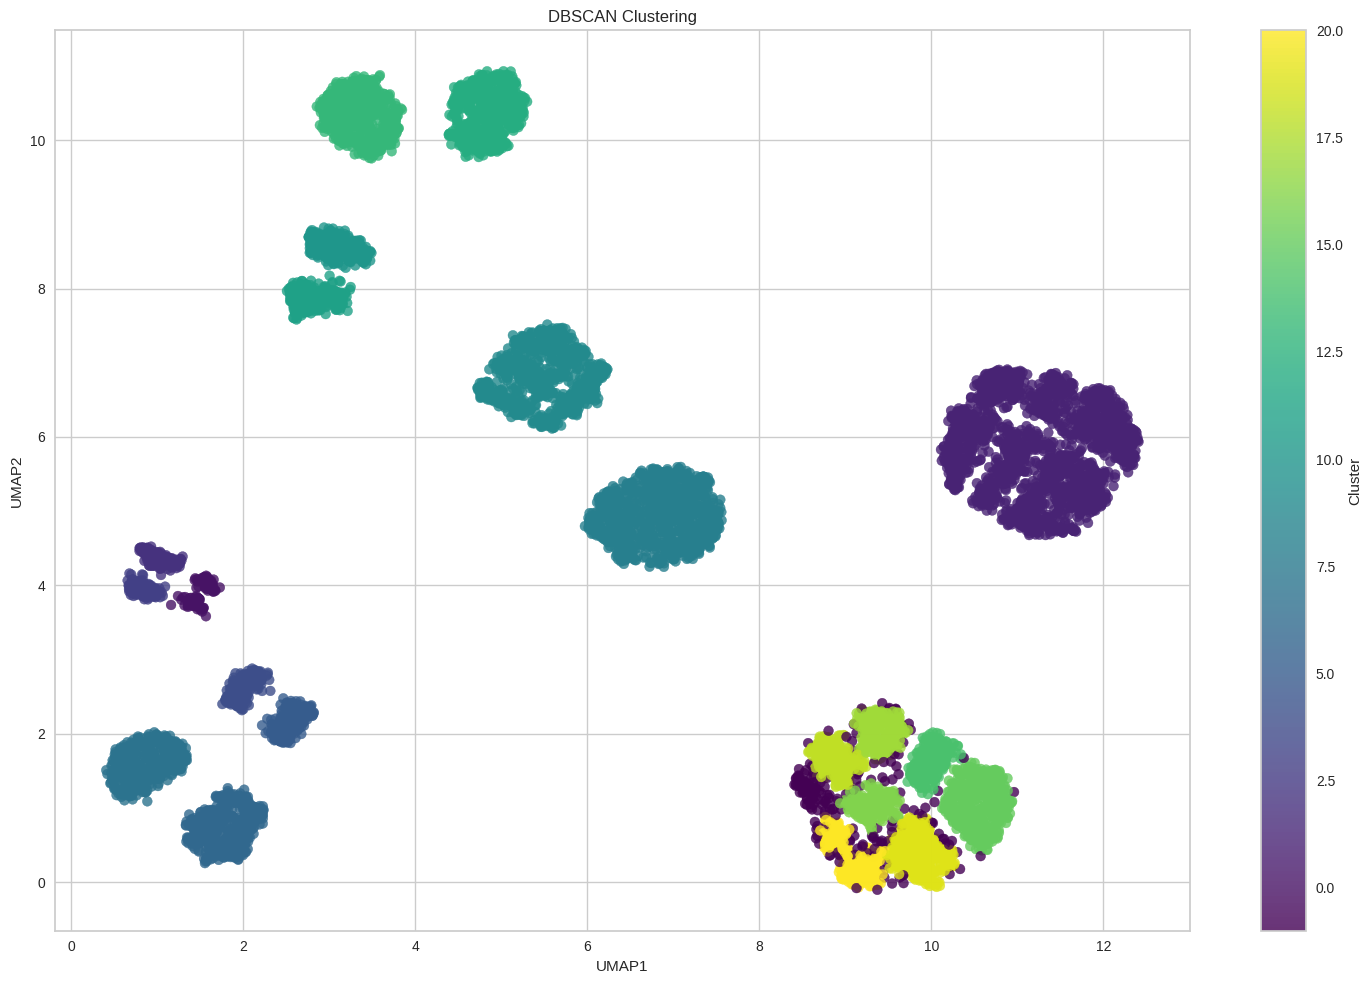

In [49]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(data_umap[:, 0], data_umap[:, 1], c=umap_hdbscan_labels, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(scatter, label='Cluster')
plt.title(f'DBSCAN Clustering')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

### **Mencoba Hyperparameter Tuning Model DBSCAN dengan Data UMAP dk_5**

> Kombinasi ini dipilih karena memiliki silhoute yang cukup tinggi tapi clusternya cukup rendah. Artinya model tidak melakukan over clustering yang membuat nilai silhoute tinggi. Target utamanya adalah mencapai nilai diatas 0.70 dan saya mencoba untuk mendapatkan cluster dibawah 10.


In [50]:
def objective(trial):
    eps = trial.suggest_float('eps', 0.1, 3.0)
    min_samples = trial.suggest_int('min_samples', 2, 100)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'chebyshev', 'minkowski'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 10, 50)
    p = trial.suggest_float('p', 1, 5) if metric == 'minkowski' else None

    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm, leaf_size=leaf_size, p=p)
    clusters = dbscan.fit_predict(data_umap)

    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

    if n_clusters < 2:
        return -1, float('inf')

    silhouette = silhouette_score(data_umap, clusters)

    return silhouette, n_clusters

study = optuna.create_study(directions=['maximize', 'minimize'])
study.optimize(objective, n_trials=200)

[I 2025-04-11 14:42:50,072] A new study created in memory with name: no-name-eed6437c-19fa-4aed-804f-1ed3de1c84de
[I 2025-04-11 14:42:51,622] Trial 0 finished with values: [0.6555175185203552, 4.0] and parameters: {'eps': 2.670872846933385, 'min_samples': 21, 'metric': 'manhattan', 'algorithm': 'ball_tree', 'leaf_size': 17}.
[I 2025-04-11 14:43:00,295] Trial 1 finished with values: [0.6993779540061951, 8.0] and parameters: {'eps': 0.9688606536438528, 'min_samples': 31, 'metric': 'minkowski', 'algorithm': 'brute', 'leaf_size': 11, 'p': 1.1673898369674527}.
[I 2025-04-11 14:43:02,634] Trial 2 finished with values: [0.6115652322769165, 15.0] and parameters: {'eps': 0.22179602505681256, 'min_samples': 89, 'metric': 'chebyshev', 'algorithm': 'brute', 'leaf_size': 16}.
[I 2025-04-11 14:43:04,142] Trial 3 finished with values: [0.7097164392471313, 5.0] and parameters: {'eps': 1.9127269279053463, 'min_samples': 49, 'metric': 'manhattan', 'algorithm': 'ball_tree', 'leaf_size': 30}.
[I 2025-04-1

In [51]:
hyperparameter_tuning_result = []

for trial in study.best_trials:
    trial_data = {
        'objective_1': trial.values[0],
        'objective_2': trial.values[1],
        **trial.params
    }
    hyperparameter_tuning_result.append(trial_data)

df_hasil_hyper = pd.DataFrame(hyperparameter_tuning_result)

In [52]:
df_hasil_hyper.sort_values(by='objective_1', ascending=False)[df_hasil_hyper['objective_2'] < 7].head(10)

objective_1  objective_2       eps  min_samples     metric  algorithm  \
18     0.709716          5.0  1.399914           30  euclidean       auto   
38     0.709716          5.0  0.951397           24  chebyshev  ball_tree   
35     0.709716          5.0  1.265345           48  euclidean    kd_tree   
32     0.709716          5.0  1.740366           85  euclidean  ball_tree   
37     0.709716          5.0  2.145862           14  manhattan  ball_tree   
25     0.709716          5.0  1.300276           87  chebyshev      brute   
26     0.709716          5.0  1.022875           33  chebyshev    kd_tree   
23     0.709716          5.0  1.700664           53  euclidean      brute   
20     0.709716          5.0  1.643077           83  euclidean      brute   
43     0.709716          5.0  1.142763           51  minkowski  ball_tree   

    leaf_size         p  
18         43       NaN  
38         26       NaN  
35         43       NaN  
32         47       NaN  
37         43       NaN  
25         34       NaN  
26         42       NaN  
23         50       NaN  
20         26       NaN  
43         29  3.423182

### **Final Training**
> Saya memilih menggunakan parameter yang menghasilkan n_cluster 5 dengan silhoute 0.70 agar proses klasifikasi lebih optimal dengan asumsi bahwa data setiap kelas akan lebih banyak karena jumlah cluster sangat minim tapi nilai silhoute tetap tinggi.

In [53]:
dbscan = DBSCAN(eps=1.516196, min_samples=67, metric='minkowski', algorithm='brute', leaf_size=35, p=4.984292)
dbscan_labels = dbscan.fit_predict(data_umap)

In [54]:
dbscan_silhouette = calculate_silhouette(dbscan_labels, data_umap)
print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")
print(f"N-Cluster: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")

DBSCAN Silhouette Score: 0.7097
N-Cluster: 5


### **Membandingkan Hasil Pelatihan**
> Pada bagian awal, telah dicoba untuk melatih model DBSCAN dengan menggunakan semua fitur data. Setelah dilatih, hasilnya tidak ada cluster yang terbentuk dari semua min_samples yang telah dicoba. Hal ini juga membuat silhoute-score tidak bisa dihitung. Selain itu, model K-means juga dicoba dengan skema yang sama, tapi hasilnya juga tidak optimal dimana silhoute_score hanya mencapai 0.0272 dengan jumlah 6 cluster.

> Setelah melakukan final traning, hasilnya lebih baik dengan silhoute score mencapai 0.7097 dan menghasilkan 5 cluster. Dapat disimpulkan bahwa model tidak melakukan overclustering.


## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

In [55]:
centroids = []
for label in dbscan_labels:
    indices = np.where(dbscan_labels == label)
    centroid = np.mean(data_umap[indices], axis=0)
    centroids.append(centroid)

centroids = np.array(centroids)

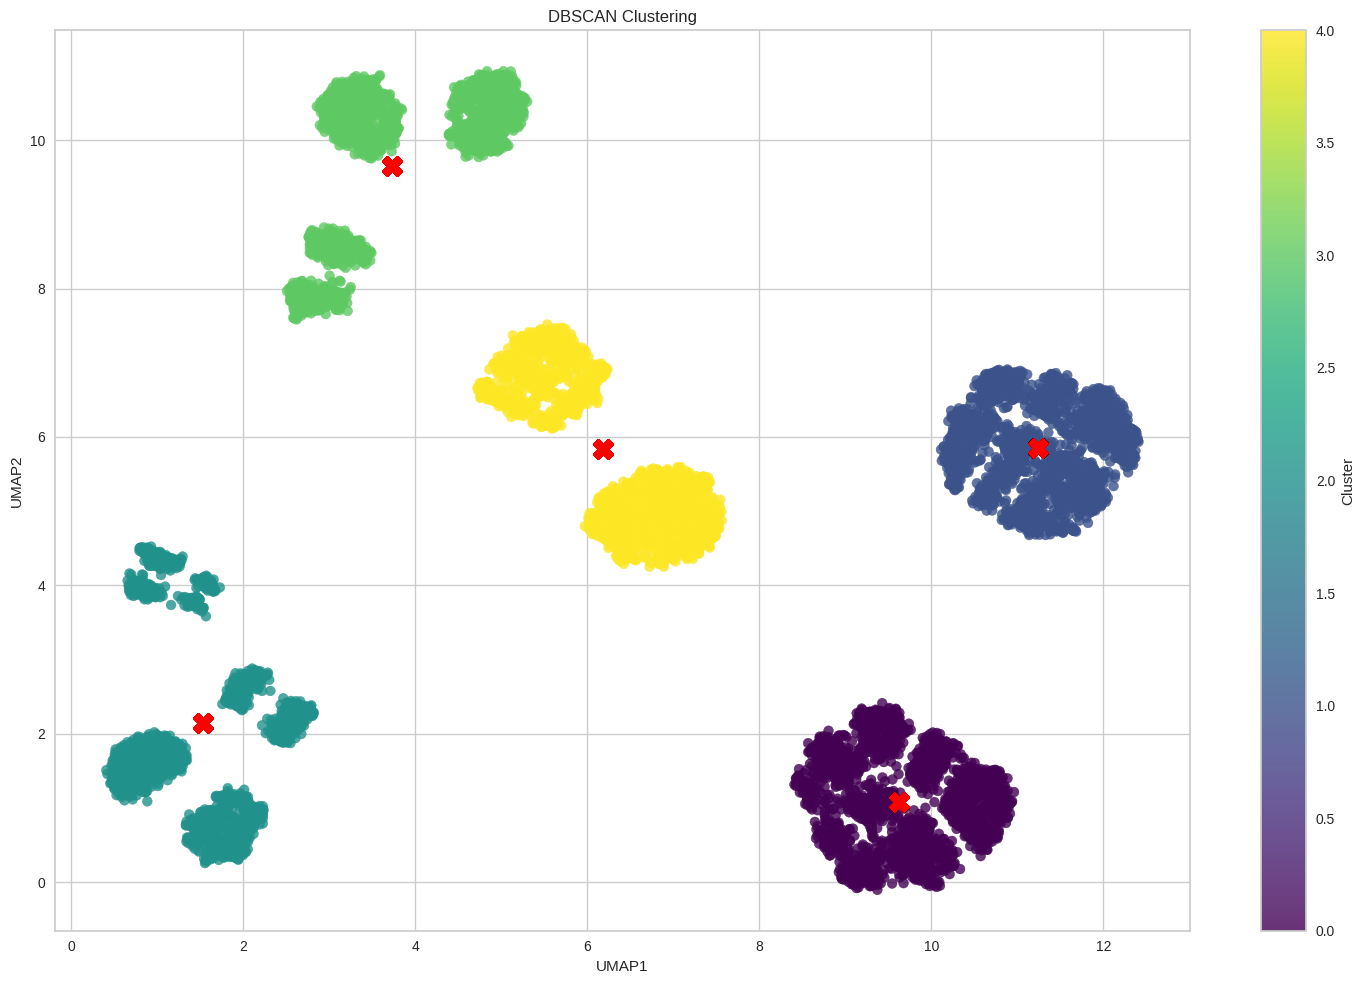

In [56]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(data_umap[:, 0], data_umap[:, 1], c=dbscan_labels, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(scatter, label='Cluster')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroid')
plt.title(f'DBSCAN Clustering')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

In [57]:
# Proses menggabungkan data UMAP dengan data preprocessing (data sebelum scaling)
df_umap = pd.DataFrame(data_umap, columns=['UMAP1', 'UMAP2'])
df_umap['Cluster'] = dbscan_labels

clustered_df = pd.concat([data_preprocessing, df_umap], axis=1)

In [58]:
gender_inv = {v: k for k, v in gender_mapping.items()}
region_inv = {v: k for k, v in region_mapping.items()}
income_inv = {v: k for k, v in income_mapping.items()}
smoking_inv = {v: k for k, v in smoking_mapping.items()}
physical_inv = {v: k for k, v in physical_mapping.items()}
dietary_inv = {v: k for k, v in dietary_mapping.items()}
air_pollution_inv = {v: k for k, v in air_pollution_mapping.items()}
stress_inv = {v: k for k, v in stress_mapping.items()}
ekg_inv = {v: k for k, v in ekg_mapping.items()}

In [59]:
clustered_df['gender'] = clustered_df['gender'].map(gender_inv)
clustered_df['region'] = clustered_df['region'].map(region_inv)
clustered_df['income_level'] = clustered_df['income_level'].map(income_inv)
clustered_df['smoking_status'] = clustered_df['smoking_status'].map(smoking_inv)
clustered_df['physical_activity'] = clustered_df['physical_activity'].map(physical_inv)
clustered_df['dietary_habits'] = clustered_df['dietary_habits'].map(dietary_inv)
clustered_df['air_pollution_exposure'] = clustered_df['air_pollution_exposure'].map(air_pollution_inv)
clustered_df['stress_level'] = clustered_df['stress_level'].map(stress_inv)
clustered_df['EKG_results'] = clustered_df['EKG_results'].map(ekg_inv)

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

### **Agregasi Data Setiap Cluster**

# Analisis Karakteristik Cluster dari Model DBSCAN

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

## Cluster 1:
- **Rata-rata Annual Income (k$):** 48,260  
- **Rata-rata Spending Score (1-100):** 56.48  
- **Analisis:** Cluster ini mencakup pelanggan dengan pendapatan tahunan menengah dan tingkat pengeluaran yang cukup tinggi. Pelanggan dalam cluster ini cenderung memiliki daya beli yang moderat dan mereka lebih cenderung untuk membelanjakan sebagian besar pendapatan mereka.

## Cluster 2:
- **Rata-rata Annual Income (k$):** 86,540  
- **Rata-rata Spending Score (1-100):** 82.13  
- **Analisis:** Cluster ini menunjukkan pelanggan dengan pendapatan tahunan tinggi dan pengeluaran yang sangat tinggi. Pelanggan di cluster ini merupakan kelompok premium dengan daya beli yang kuat dan cenderung mengeluarkan uang dalam jumlah besar untuk produk atau layanan.

## Cluster 3:
- **Rata-rata Annual Income (k$):** 87,000  
- **Rata-rata Spending Score (1-100):** 18.63  
- **Analisis:** Cluster ini terdiri dari pelanggan dengan pendapatan tahunan yang tinggi tetapi pengeluaran yang rendah. Mereka mungkin memiliki kapasitas finansial yang baik namun tidak terlalu aktif dalam berbelanja. Ini bisa menunjukkan bahwa mereka lebih selektif dalam pengeluaran mereka atau mungkin lebih cenderung untuk menyimpan uang.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.